In [2]:
import openml
import os
import numpy as np
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score
from tqdm import tqdm
# import train test split
from sklearn.model_selection import train_test_split
openml.config.cache_directory = os.path.expanduser('/storage/store/work/lgrinszt/openml_cache')

In [3]:

import random
import time
import warnings
from datetime import datetime

import torch

import numpy as np

import matplotlib.pyplot as plt
from scripts.differentiable_pfn_evaluation import eval_model_range
from scripts.model_builder import get_model, get_default_spec, save_model, load_model
from scripts.transformer_prediction_interface import transformer_predict, get_params_from_config, load_model_workflow

from scripts.model_configs import *

from datasets import load_openml_list, open_cc_dids, open_cc_valid_dids
from priors.utils import plot_prior, plot_features
from priors.utils import uniform_int_sampler_f

from scripts.tabular_metrics import calculate_score_per_method, calculate_score
from scripts.tabular_evaluation import evaluate

from priors.differentiable_prior import DifferentiableHyperparameterList, draw_random_style, merge_style_with_info
from scripts import tabular_metrics
from notebook_utils import *
import argparse
import wandb 

/home/parietal/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/xgboost/compat.py:31: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [4]:
def load_model(path, filename, device, config_sample, verbose=0):
    # TODO: This function only restores evaluation functionality but training canät be continued. It is also not flexible.
    # print('Loading....')
    model_state = torch.load(
        os.path.join(path, filename), map_location='cpu')
    if ('differentiable_hyperparameters' in config_sample
            and 'prior_mlp_activations' in config_sample['differentiable_hyperparameters']):
        config_sample['differentiable_hyperparameters']['prior_mlp_activations']['choice_values_used'] = config_sample[
                                                                                                         'differentiable_hyperparameters'][
                                                                                                         'prior_mlp_activations'][
                                                                                                         'choice_values']
        config_sample['differentiable_hyperparameters']['prior_mlp_activations']['choice_values'] = [
            torch.nn.Tanh for k in config_sample['differentiable_hyperparameters']['prior_mlp_activations']['choice_values']]

    config_sample['categorical_features_sampler'] = lambda: lambda x: ([], [], [])
    config_sample['num_features_used_in_training'] = config_sample['num_features_used']
    config_sample['num_features_used'] = lambda: config_sample['num_features']
    config_sample['num_classes_in_training'] = config_sample['num_classes']
    config_sample['num_classes'] = 2
    config_sample['batch_size_in_training'] = config_sample['batch_size']
    config_sample['batch_size'] = 1
    config_sample['bptt_in_training'] = config_sample['bptt']
    config_sample['bptt'] = 10 #WHY
    config_sample['bptt_extra_samples_in_training'] = config_sample['bptt_extra_samples']
    config_sample['bptt_extra_samples'] = None

    #print('Memory', str(get_gpu_memory()))

    model = get_model(config_sample, device=device, should_train=False, verbose=verbose)
    module_prefix = 'module.'
    model_state = {k.replace(module_prefix, ''): v for k, v in model_state.items()}
    model[2].load_state_dict(model_state)
    model[2].to(device)
    model[2].eval()

    return model, config_sample

In [5]:
large_datasets = True
max_samples = 10000 if large_datasets else 5000
bptt = 10000 if large_datasets else 3000
suite='cc'
base_path = '.'
max_features = 100

args = argparse.Namespace()
args.prior = "trees"
args.task_type = 'multiclass'
args.device = 4
args.wandb = False
args.name = "test"
args.save_every = 59

device = 'cuda:{}'.format(args.device) if args.device >= 0 else 'cpu'


def print_models(model_string):
    print(model_string)

    for i in range(80):
        for e in range(50):
            exists = Path(os.path.join(base_path, f'models_diff/prior_diff_real_checkpoint{model_string}_n_{i}_epoch_{e}.cpkt')).is_file()
            if exists:
                print(os.path.join(base_path, f'models_diff/prior_diff_real_checkpoint{model_string}_n_{i}_epoch_{e}.cpkt'))
        print()
def train_function(config_sample, i, add_name=''):
    start_time = time.time()
    N_epochs_to_save = 50
    
    def save_callback(model, epoch):
        if not hasattr(model, 'last_saved_epoch'):
            model.last_saved_epoch = 0
        if ((time.time() - start_time) / (maximum_runtime * 60 / N_epochs_to_save)) > model.last_saved_epoch:
            print('Saving model..')
            config_sample['epoch_in_training'] = epoch
            save_model(model, base_path, f'models_diff/prior_diff_real_checkpoint{add_name}_n_{i}_epoch_{model.last_saved_epoch}.cpkt',
                           config_sample)
            model.last_saved_epoch = model.last_saved_epoch + 1 # TODO: Rename to checkpoint
    
    model = get_model(config_sample
                      , device
                      , should_train=True
                      , verbose=1
                      , epoch_callback = save_callback)
    
    return



def reload_config(config_type='causal', task_type='multiclass', longer=0):
    config = get_prior_config(config_type=config_type)
    
    config['prior_type'], config['differentiable'], config['flexible'] = args.prior, True, True
    
    model_string = ''
    
    config['epochs'] = 12000
    config['recompute_attn'] = True

    config['max_num_classes'] = 10
    config['num_classes'] = uniform_int_sampler_f(2, config['max_num_classes'])
    config['balanced'] = False
    model_string = model_string + '_multiclass'
    
    model_string = model_string + '_'+datetime.now().strftime("%m_%d_%Y_%H_%M_%S")
    
    return config, model_string

config, model_string = reload_config(longer=1)

config['bptt_extra_samples'] = None

config["sampling"] = "mixed"
del config['differentiable_hyperparameters']['sampling']
config["num_classes"] = 2

if config['prior_type'] == 'trees':
    config["n_trees"] = 25
    config["max_depth"] = 10
    config["depth_distribution"] = "uniform"
    config["split_distribution"] = "uniform"
    config["split_param"] = 1
elif config['prior_type'] == 'mlp':
    config['output_multiclass_ordered_p'] = 0.
    del config['differentiable_hyperparameters']['output_multiclass_ordered_p']

    config['multiclass_type'] = 'rank'
    del config['differentiable_hyperparameters']['multiclass_type']

    config['pre_sample_causes'] = True



config['multiclass_loss_type'] = 'nono' # 'compatible'
config['normalize_to_ranking'] = False # False

config['categorical_feature_p'] = .2 # diff: .0

# turn this back on in a random search!?
config['nan_prob_no_reason'] = .0
config['nan_prob_unknown_reason'] = .0 # diff: .0
config['set_value_to_nan'] = .1 # diff: 1.

config['normalize_with_sqrt'] = False

config['new_mlp_per_example'] = True
config['prior_mlp_scale_weights_sqrt'] = True
config['batch_size_per_gp_sample'] = None

config['normalize_ignore_label_too'] = False

config['differentiable_hps_as_style'] = False
config['max_eval_pos'] = 1000

config['random_feature_rotation'] = True
config['rotate_normalized_labels'] = True

config["mix_activations"] = False # False heisst eig True

config['emsize'] = 512
config['nhead'] = config['emsize'] // 128
config['bptt'] = 1024+128
config['canonical_y_encoder'] = False

    
config['aggregate_k_gradients'] = 8
config['batch_size'] = 8*config['aggregate_k_gradients']
config['num_steps'] = 1024//config['aggregate_k_gradients']
config['epochs'] = 400
config['total_available_time_in_s'] = None #60*60*22 # 22 hours for some safety...

config['train_mixed_precision'] = True
config['efficient_eval_masking'] = True

config["use_wandb"] = args.wandb
config["name"] = args.name
config["save_every"] = args.save_every

if args.wandb == True:
    wandb.init(project="tabpfn_training", entity="leogrin")
    wandb.config.update(config)

config_sample = evaluate_hypers(config)

In [6]:
from tabpfn.scripts.transformer_prediction_interface import TabPFNClassifier

model = TabPFNClassifier()

Using style prior: True
{'recompute_attn': True}
<module 'wandb' from '/home/parietal/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/wandb/__init__.py'>
Using cpu device
Batch size: 1
Using a Transformer with 25.82 M parameters


In [7]:
import openml
from sklearn.preprocessing import LabelEncoder
import pandas as pd
def balance_data(x, y):
    rng = np.random.RandomState(0)
    print("Balancing")
    print(x.shape)
    indices = [(y == i) for i in np.unique(y)]
    sorted_classes = np.argsort(
        list(map(sum, indices)))  # in case there are more than 2 classes, we take the two most numerous

    n_samples_min_class = sum(indices[sorted_classes[-2]])
    print("n_samples_min_class", n_samples_min_class)
    indices_max_class = rng.choice(np.where(indices[sorted_classes[-1]])[0], n_samples_min_class, replace=False)
    indices_min_class = np.where(indices[sorted_classes[-2]])[0]
    total_indices = np.concatenate((indices_max_class, indices_min_class))
    y = y[total_indices]
    indices_first_class = (y == sorted_classes[-1])
    indices_second_class = (y == sorted_classes[-2])
    y[indices_first_class] = 0
    y[indices_second_class] = 1

    return x.iloc[total_indices], y
def import_open_ml_data(dataset_id=None, task_id=None, remove_nans=None, impute_nans=None, categorical=False, regression=False, balance=False, rng=None) -> pd.DataFrame:
    """
    Import data from openML
    :param int openml_task_id:
    :param path_to_file:
    :return:
    """
    if task_id is not None:
        task = openml.tasks.get_task(task_id)  # download the OpenML task
        dataset = task.get_dataset()
    elif dataset_id is not None:
        dataset = openml.datasets.get_dataset(dataset_id)
    # retrieve categorical data for encoding
    X, y, categorical_indicator, attribute_names = dataset.get_data(
        dataset_format="dataframe", target=dataset.default_target_attribute
    )
    categorical_indicator = np.array(categorical_indicator)
    print("{} categorical columns".format(sum(categorical_indicator)))
    print("{} columns".format(X.shape[1]))
    y_encoder = LabelEncoder()

    # Replace categorical values by integers for each categorical column
    for i, categorical in enumerate(categorical_indicator):
        X.iloc[:, i] = X.iloc[:, i].astype('category')
        X.iloc[:, i] = X.iloc[:, i].cat.codes
        X.iloc[:, i] = X.iloc[:, i].astype('int64')

    # remove missing values
    assert remove_nans or impute_nans, "You need to remove or impute nans"
    if remove_nans:
        missing_rows_mask = X.isnull().any(axis=1)
        if sum(missing_rows_mask) > X.shape[0] / 5:
            print("Removed {} rows with missing values on {} rows".format(
                sum(missing_rows_mask), X.shape[0]))
        X = X[~missing_rows_mask]
        y = y[~missing_rows_mask]
        n_rows_non_missing = X.shape[0]
        if n_rows_non_missing == 0:
            print("Removed all rows")
            return None
    elif impute_nans:
        from sklearn.impute import SimpleImputer
        # Impute numerical columns with mean and categorical columns with most frequent
        categorical_imputer = SimpleImputer(strategy="most_frequent")
        numerical_imputer = SimpleImputer(strategy="mean")
        # check that there a > 0 categorical columns
        if sum(categorical_indicator) > 0:
            X.iloc[:, categorical_indicator] = categorical_imputer.fit_transform(X.iloc[:, categorical_indicator])
        # check that there a > 0 numerical columns
        if sum(~categorical_indicator) > 0:
            X.iloc[:, ~categorical_indicator] = numerical_imputer.fit_transform(X.iloc[:, ~categorical_indicator])




    # print("removing {} categorical features among {} features".format(sum(categorical_indicator), X.shape[1]))
    # X = X.to_numpy()[:, ~categorical_indicator]  # remove all categorical columns
    # if X.shape[1] == 0:
    #     print("removed all features, skipping this task")
    #     return None

    y = y_encoder.fit_transform(y)



    if regression:
        y = y.astype(np.float64)
    else:
        y = y.astype(np.int64)

    if balance:
        X, y = balance_data(X, y)

    X = X.to_numpy()

    if categorical:
        return X, y, categorical_indicator

    return X, y, None

In [8]:
# Choose tasks with less than 100 features
suite = openml.study.get_suite(337)
tasks = suite.tasks
accepted_tasks = []
for task_id in tasks:
    print("Task id: {}".format(task_id))
    X, y, _ = import_open_ml_data(task_id=task_id, remove_nans=True, impute_nans=False, categorical=False, regression=False, balance=True, rng=None)
    if X.shape[1] > 100:
        print("skipping task {} because it has too many features".format(task_id))
        continue
    if X is None:
        print("skipping task {} because it has no features".format(task_id))
        continue
    accepted_tasks.append(task_id)


Task id: 361055
0 categorical columns
10 columns


/tmp/ipykernel_5666/406963134.py:48: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  X.iloc[:, i] = X.iloc[:, i].cat.codes
/tmp/ipykernel_5666/406963134.py:48: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  X.iloc[:, i] = X.iloc[:, i].cat.codes
/tmp/ipykernel_5666/406963134.py:48: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newval

Balancing
(16714, 10)
n_samples_min_class 8357
Task id: 361060
0 categorical columns
7 columns


/tmp/ipykernel_5666/406963134.py:48: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  X.iloc[:, i] = X.iloc[:, i].cat.codes
/tmp/ipykernel_5666/406963134.py:48: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  X.iloc[:, i] = X.iloc[:, i].cat.codes
/tmp/ipykernel_5666/406963134.py:48: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newval

Balancing
(38474, 7)
n_samples_min_class 19237
Task id: 361061
0 categorical columns
10 columns


/tmp/ipykernel_5666/406963134.py:48: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  X.iloc[:, i] = X.iloc[:, i].cat.codes
/tmp/ipykernel_5666/406963134.py:48: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  X.iloc[:, i] = X.iloc[:, i].cat.codes
/tmp/ipykernel_5666/406963134.py:48: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newval

Balancing
(566602, 10)
n_samples_min_class 283301
Task id: 361062
0 categorical columns
26 columns


/tmp/ipykernel_5666/406963134.py:48: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  X.iloc[:, i] = X.iloc[:, i].cat.codes
/tmp/ipykernel_5666/406963134.py:48: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  X.iloc[:, i] = X.iloc[:, i].cat.codes
/tmp/ipykernel_5666/406963134.py:48: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newval

Balancing
(10082, 26)
n_samples_min_class 5041
Task id: 361063
0 categorical columns
16 columns
Balancing
(13488, 16)
n_samples_min_class 6744
Task id: 361065
0 categorical columns
10 columns


/tmp/ipykernel_5666/406963134.py:48: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  X.iloc[:, i] = X.iloc[:, i].cat.codes
/tmp/ipykernel_5666/406963134.py:48: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  X.iloc[:, i] = X.iloc[:, i].cat.codes
/tmp/ipykernel_5666/406963134.py:48: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newval

Balancing
(13376, 10)
n_samples_min_class 6688
Task id: 361066
0 categorical columns
7 columns
Balancing
(10578, 7)
n_samples_min_class 5289
Task id: 361068
0 categorical columns
50 columns


/tmp/ipykernel_5666/406963134.py:48: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  X.iloc[:, i] = X.iloc[:, i].cat.codes
/tmp/ipykernel_5666/406963134.py:48: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  X.iloc[:, i] = X.iloc[:, i].cat.codes
/tmp/ipykernel_5666/406963134.py:48: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newval

Balancing
(72998, 50)
n_samples_min_class 36499
Task id: 361069
0 categorical columns
24 columns


/tmp/ipykernel_5666/406963134.py:48: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  X.iloc[:, i] = X.iloc[:, i].cat.codes
/tmp/ipykernel_5666/406963134.py:48: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  X.iloc[:, i] = X.iloc[:, i].cat.codes
/tmp/ipykernel_5666/406963134.py:48: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newval

Balancing
(940160, 24)
n_samples_min_class 470080
Task id: 361070
0 categorical columns
20 columns


/tmp/ipykernel_5666/406963134.py:48: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  X.iloc[:, i] = X.iloc[:, i].cat.codes
/tmp/ipykernel_5666/406963134.py:48: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  X.iloc[:, i] = X.iloc[:, i].cat.codes
/tmp/ipykernel_5666/406963134.py:48: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newval

Balancing
(7608, 20)
n_samples_min_class 3804
Task id: 361273
0 categorical columns
7 columns


/tmp/ipykernel_5666/406963134.py:48: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  X.iloc[:, i] = X.iloc[:, i].cat.codes
/tmp/ipykernel_5666/406963134.py:48: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  X.iloc[:, i] = X.iloc[:, i].cat.codes
/tmp/ipykernel_5666/406963134.py:48: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newval

Balancing
(71090, 7)
n_samples_min_class 35545
Task id: 361274
0 categorical columns
54 columns


/tmp/ipykernel_5666/406963134.py:48: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  X.iloc[:, i] = X.iloc[:, i].cat.codes
/tmp/ipykernel_5666/406963134.py:48: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  X.iloc[:, i] = X.iloc[:, i].cat.codes
/tmp/ipykernel_5666/406963134.py:48: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newval

Balancing
(57580, 54)
n_samples_min_class 28790
Task id: 361275
0 categorical columns
20 columns


/tmp/ipykernel_5666/406963134.py:48: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  X.iloc[:, i] = X.iloc[:, i].cat.codes
/tmp/ipykernel_5666/406963134.py:48: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  X.iloc[:, i] = X.iloc[:, i].cat.codes
/tmp/ipykernel_5666/406963134.py:48: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newval

Balancing
(13272, 20)
n_samples_min_class 6636
Task id: 361276
0 categorical columns
419 columns


/tmp/ipykernel_5666/406963134.py:48: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  X.iloc[:, i] = X.iloc[:, i].cat.codes
/tmp/ipykernel_5666/406963134.py:48: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  X.iloc[:, i] = X.iloc[:, i].cat.codes
/tmp/ipykernel_5666/406963134.py:48: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newval

Balancing
(3434, 419)
n_samples_min_class 1717
skipping task 361276 because it has too many features
Task id: 361277
0 categorical columns
8 columns


/tmp/ipykernel_5666/406963134.py:48: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  X.iloc[:, i] = X.iloc[:, i].cat.codes
/tmp/ipykernel_5666/406963134.py:48: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  X.iloc[:, i] = X.iloc[:, i].cat.codes
/tmp/ipykernel_5666/406963134.py:48: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newval

Balancing
(20634, 8)
n_samples_min_class 10317
Task id: 361278
0 categorical columns
22 columns
Balancing
(10000, 22)
n_samples_min_class 5000


/tmp/ipykernel_5666/406963134.py:48: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  X.iloc[:, i] = X.iloc[:, i].cat.codes
/tmp/ipykernel_5666/406963134.py:48: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  X.iloc[:, i] = X.iloc[:, i].cat.codes
/tmp/ipykernel_5666/406963134.py:48: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newval

In [8]:
model = TabPFNClassifier(no_preprocess_mode=True)
checkpoint = "trees13368_60"
model_pytorch = load_model("tabpfn/model_checkpoints", f"model_{checkpoint}.pt", 2, model.c, 0)[0]
model.model = model_pytorch

Using style prior: True
{'recompute_attn': True}
<module 'wandb' from '/home/parietal/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/wandb/__init__.py'>
Using cpu device
Batch size: 1
Using a Transformer with 25.82 M parameters
Using style prior: True
{'recompute_attn': True}
<module 'wandb' from '/home/parietal/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/wandb/__init__.py'>
Using 2 device
Batch size: 1
Using a Transformer with 25.82 M parameters
Using distributed training: False


In [61]:
task_id = 361069
checkpoint = "trees13368_60"
def create_model():
    model = TabPFNClassifier()#no_preprocess_mode=False, device="cuda:1")
    model_pytorch = load_model("tabpfn/model_checkpoints", f"model_{checkpoint}.pt", 1, config_sample, 0)[0]
    model.model = model_pytorch
    return model
model = create_model

X, y, _ = import_open_ml_data(task_id=task_id, remove_nans=True, impute_nans=False, categorical=False, regression=False, balance=True, rng=None)
accuracies = []
for i in range(n_repeat):
    # Split the data into a training set and a test set
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=i+10)

    # Restrict to 1000 samples for faster training
    X_train, y_train = X_train[:1000], y_train[:1000]
    X_test, y_test = X_test[:5000], y_test[:5000]

    clf = model()
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(accuracy)
    accuracies.append(accuracy)
    
print("Mean accuracy: {}".format(np.mean(accuracies)))
print(accuracies)



0 categorical columns
24 columns


/tmp/ipykernel_5666/406963134.py:48: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  X.iloc[:, i] = X.iloc[:, i].cat.codes
/tmp/ipykernel_5666/406963134.py:48: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  X.iloc[:, i] = X.iloc[:, i].cat.codes
/tmp/ipykernel_5666/406963134.py:48: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newval

Balancing
(940160, 24)
n_samples_min_class 470080
Using style prior: True
{'recompute_attn': True}
<module 'wandb' from '/home/parietal/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/wandb/__init__.py'>
Using cpu device
Batch size: 1
Using a Transformer with 25.82 M parameters
{'lr': 0.00012233099806627348, 'dropout': 0.0, 'emsize': 512, 'batch_size': 1, 'nlayers': 12, 'num_features': 100, 'nhead': 4, 'nhid_factor': 2, 'bptt': 10, 'eval_positions': [9], 'seq_len_used': 50, 'sampling': 'mixed', 'epochs': 400, 'num_steps': 356811923176489970264571492362373784095686656, 'verbose': False, 'mix_activations': False, 'pre_sample_causes': True, 'multiclass_type': 'rank', 'nan_prob_unknown_reason_reason_prior': 0.5, 'categorical_feature_p': 0.2, 'nan_prob_no_reason': 0.0, 'nan_prob_unknown_reason': 0.0, 'nan_prob_a_reason': 0.0, 'max_num_classes': 10, 'num_classes': 2, 'noise_type': 'Gaussian', 'balanced': False, 'normalize_to_ranking': False, 'set_value_to_nan': 0.1, 'nor

In [65]:
results = pd.read_csv("results.csv")
results[(results["model"] == "trees13368_60_no_prepro2") & (results["task_id"] == 361069)]

,Unnamed: 0.12,Unnamed: 0.11,Unnamed: 0.10,Unnamed: 0.9,Unnamed: 0.8,Unnamed: 0.7,Unnamed: 0.6,Unnamed: 0.5,Unnamed: 0.4,Unnamed: 0.3,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,task_id,seed,accuracy,model
633,633,633.0,633.0,633.0,633.0,633.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,361069,0,0.6768,trees13368_60_no_prepro2
635,635,635.0,635.0,635.0,635.0,635.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,361069,1,0.6790,trees13368_60_no_prepro2
637,637,637.0,637.0,637.0,637.0,637.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,361069,2,0.6750,trees13368_60_no_prepro2


In [25]:
# Do the same thing for all tasks in openml suite 2
# and put everything in a pd dataframe
import pandas as pd


# Create a dataframe to store the results
# check if already exists
try:
    results = pd.read_csv("results.csv")
    print("results already exists, appending to it")
except FileNotFoundError:
    print("results does not exist, creating it")
    results = pd.DataFrame(columns=["task_id", "seed", "accuracy", "model"])

# models = {"Random Forest": RandomForestClassifier,
#           "Gradient Boosting": GradientBoostingClassifier,
#           "Logistic Regression": LogisticRegression,
#           "TabPFN": TabPFNClassifier,
#           "TabPFNne": lambda: TabPFNClassifier(N_ensemble_configurations=1),
#           "TabPFNno_prepro": lambda: TabPFNClassifier(no_preprocess_mode=True)}
models = {}

#checkpoints = ["default35970_260", "trees13368_60", "trees456_390", "trees66554_75", "mlp60400_160", "mlp71353_400"]
#checkpoints = ["default35702_250", "trees79428_250"]
checkpoints = ["trees13368_60"]
for checkpoint in checkpoints:
    def create_model():
        model = TabPFNClassifier(no_preprocess_mode=True, device="cuda:0", feature_shift_decoder=False)
        model_pytorch = load_model("tabpfn/model_checkpoints", f"model_{checkpoint}.pt", 0, model.c, 0)[0]
        model.model = model_pytorch
        return model
    models[f"{checkpoint}_test"] = create_model 



n_repeat = 3

for task_id in tqdm(accepted_tasks):
    print("Task id: {}".format(task_id))
    X, y, _ = import_open_ml_data(task_id=task_id, remove_nans=True, impute_nans=False, categorical=False, regression=False, balance=True, rng=None)
    if X.shape[1] > 100:
        print("skipping task {} because it has too many features".format(task_id))
        continue
    if X is None:
        print("skipping task {} because it has no features".format(task_id))
        continue

    # Evaluate the models n_repeat times

    for i in range(n_repeat):
        # Split the data into a training set and a test set
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=i)

        # Restrict to 1000 samples for faster training
        X_train, y_train = X_train[:1000], y_train[:1000]
        X_test, y_test = X_test[:5000], y_test[:5000]

        for model_name, model in models.items():
            # check if already exists
            if sum((results["task_id"] == task_id) & (results["seed"] == i) & (results["model"] == model_name)) > 0:
                #print("results already exists, skipping")
                #continue
                print(results[(results["task_id"] == task_id) & (results["seed"] == i) & (results["model"] == model_name)])
            print("model: {}".format(model_name))
            clf = model()
            clf.fit(X_train, y_train)
            y_pred = clf.predict(X_test)
            accuracy = accuracy_score(y_test, y_pred)
            print(accuracy)
            results = results.append({"task_id": task_id, "seed": i, "accuracy": accuracy, "model": model_name}, ignore_index=True)
            #replace with concat
            results = pd.concat([results, pd.DataFrame({"task_id": [task_id], "seed": [i], "accuracy": [accuracy], "model": [model_name]})], ignore_index=True)
#results.to_csv("results.csv")    




results already exists, appending to it


  0%|          | 0/15 [00:00<?, ?it/s]

Task id: 361055
0 categorical columns
10 columns
Balancing
(16714, 10)
n_samples_min_class 8357
model: trees13368_60_test


/tmp/ipykernel_5666/406963134.py:48: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  X.iloc[:, i] = X.iloc[:, i].cat.codes
/tmp/ipykernel_5666/406963134.py:48: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  X.iloc[:, i] = X.iloc[:, i].cat.codes
/tmp/ipykernel_5666/406963134.py:48: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newval

Using style prior: True
{'recompute_attn': True}
<module 'wandb' from '/home/parietal/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/wandb/__init__.py'>
Using cuda:0 device
Batch size: 1
Using a Transformer with 25.82 M parameters
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Using style prior: True
{'recompute_attn': True}
<module 'wandb' from '/home/parietal/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/wandb/__init__.py'>
Using 0 device
Batch size: 1
Using a Transformer with 25.82 M parameters
Using distributed training: False
interface
torch.Size([4343, 1, 10])
torch.Size([4343, 1])
1000
0.7660783727191146
model: trees13368_60_test


/tmp/ipykernel_5666/3695851834.py:70: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({"task_id": task_id, "seed": i, "accuracy": accuracy, "model": model_name}, ignore_index=True)


Using style prior: True
{'recompute_attn': True}
<module 'wandb' from '/home/parietal/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/wandb/__init__.py'>
Using cuda:0 device
Batch size: 1
Using a Transformer with 25.82 M parameters
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Using style prior: True
{'recompute_attn': True}
<module 'wandb' from '/home/parietal/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/wandb/__init__.py'>
Using 0 device
Batch size: 1
Using a Transformer with 25.82 M parameters
Using distributed training: False
interface
torch.Size([4343, 1, 10])
torch.Size([4343, 1])
1000
0.7636853125934789
model: trees13368_60_test


/tmp/ipykernel_5666/3695851834.py:70: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({"task_id": task_id, "seed": i, "accuracy": accuracy, "model": model_name}, ignore_index=True)


Using style prior: True
{'recompute_attn': True}
<module 'wandb' from '/home/parietal/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/wandb/__init__.py'>
Using cuda:0 device
Batch size: 1
Using a Transformer with 25.82 M parameters
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Using style prior: True
{'recompute_attn': True}
<module 'wandb' from '/home/parietal/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/wandb/__init__.py'>
Using 0 device
Batch size: 1
Using a Transformer with 25.82 M parameters
Using distributed training: False


/tmp/ipykernel_5666/3695851834.py:70: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({"task_id": task_id, "seed": i, "accuracy": accuracy, "model": model_name}, ignore_index=True)
  7%|▋         | 1/15 [00:06<01:27,  6.23s/it]

interface
torch.Size([4343, 1, 10])
torch.Size([4343, 1])
1000
0.7454382291355071
Task id: 361060


/tmp/ipykernel_5666/406963134.py:48: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  X.iloc[:, i] = X.iloc[:, i].cat.codes
/tmp/ipykernel_5666/406963134.py:48: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  X.iloc[:, i] = X.iloc[:, i].cat.codes
/tmp/ipykernel_5666/406963134.py:48: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newval

0 categorical columns
7 columns
Balancing
(38474, 7)
n_samples_min_class 19237
model: trees13368_60_test
Using style prior: True
{'recompute_attn': True}
<module 'wandb' from '/home/parietal/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/wandb/__init__.py'>
Using cuda:0 device
Batch size: 1
Using a Transformer with 25.82 M parameters
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Using style prior: True
{'recompute_attn': True}
<module 'wandb' from '/home/parietal/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/wandb/__init__.py'>
Using 0 device
Batch size: 1
Using a Transformer with 25.82 M parameters
Using distributed training: False
interface
torch.Size([6000, 1, 7])
torch.Size([6000, 1])
1000
0.7736
model: trees13368_60_test
Using style prior: True
{'recompute_attn': True}
<module 'wandb' from '/home/parietal/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/wand

/tmp/ipykernel_5666/3695851834.py:70: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({"task_id": task_id, "seed": i, "accuracy": accuracy, "model": model_name}, ignore_index=True)


Using a Transformer with 25.82 M parameters
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Using style prior: True
{'recompute_attn': True}
<module 'wandb' from '/home/parietal/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/wandb/__init__.py'>
Using 0 device
Batch size: 1
Using a Transformer with 25.82 M parameters
Using distributed training: False
interface
torch.Size([6000, 1, 7])
torch.Size([6000, 1])
1000
0.7958
model: trees13368_60_test
Using style prior: True
{'recompute_attn': True}
<module 'wandb' from '/home/parietal/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/wandb/__init__.py'>
Using cuda:0 device
Batch size: 1


/tmp/ipykernel_5666/3695851834.py:70: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({"task_id": task_id, "seed": i, "accuracy": accuracy, "model": model_name}, ignore_index=True)


Using a Transformer with 25.82 M parameters
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Using style prior: True
{'recompute_attn': True}
<module 'wandb' from '/home/parietal/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/wandb/__init__.py'>
Using 0 device
Batch size: 1
Using a Transformer with 25.82 M parameters
Using distributed training: False
interface
torch.Size([6000, 1, 7])
torch.Size([6000, 1])
1000


/tmp/ipykernel_5666/3695851834.py:70: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({"task_id": task_id, "seed": i, "accuracy": accuracy, "model": model_name}, ignore_index=True)
 13%|█▎        | 2/15 [00:12<01:23,  6.41s/it]

0.7658
Task id: 361061
0 categorical columns
10 columns


/tmp/ipykernel_5666/406963134.py:48: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  X.iloc[:, i] = X.iloc[:, i].cat.codes
/tmp/ipykernel_5666/406963134.py:48: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  X.iloc[:, i] = X.iloc[:, i].cat.codes
/tmp/ipykernel_5666/406963134.py:48: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newval

Balancing
(566602, 10)
n_samples_min_class 283301
model: trees13368_60_test
Using style prior: True
{'recompute_attn': True}
<module 'wandb' from '/home/parietal/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/wandb/__init__.py'>
Using cuda:0 device
Batch size: 1
Using a Transformer with 25.82 M parameters
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Using style prior: True
{'recompute_attn': True}
<module 'wandb' from '/home/parietal/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/wandb/__init__.py'>
Using 0 device
Batch size: 1
Using a Transformer with 25.82 M parameters
Using distributed training: False
interface
torch.Size([6000, 1, 10])
torch.Size([6000, 1])
1000
0.7528


/tmp/ipykernel_5666/3695851834.py:70: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({"task_id": task_id, "seed": i, "accuracy": accuracy, "model": model_name}, ignore_index=True)


model: trees13368_60_test
Using style prior: True
{'recompute_attn': True}
<module 'wandb' from '/home/parietal/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/wandb/__init__.py'>
Using cuda:0 device
Batch size: 1
Using a Transformer with 25.82 M parameters
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Using style prior: True
{'recompute_attn': True}
<module 'wandb' from '/home/parietal/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/wandb/__init__.py'>
Using 0 device
Batch size: 1
Using a Transformer with 25.82 M parameters
Using distributed training: False
interface
torch.Size([6000, 1, 10])
torch.Size([6000, 1])
1000
0.7644
model: trees13368_60_test
Using style prior: True
{'recompute_attn': True}
<module 'wandb' from '/home/parietal/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/wandb/__init__.py'>
Using cuda:0 device
Batch size: 1


/tmp/ipykernel_5666/3695851834.py:70: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({"task_id": task_id, "seed": i, "accuracy": accuracy, "model": model_name}, ignore_index=True)


Using a Transformer with 25.82 M parameters
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Using style prior: True
{'recompute_attn': True}
<module 'wandb' from '/home/parietal/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/wandb/__init__.py'>
Using 0 device
Batch size: 1
Using a Transformer with 25.82 M parameters
Using distributed training: False


/tmp/ipykernel_5666/3695851834.py:70: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({"task_id": task_id, "seed": i, "accuracy": accuracy, "model": model_name}, ignore_index=True)
 20%|██        | 3/15 [00:21<01:28,  7.36s/it]

interface
torch.Size([6000, 1, 10])
torch.Size([6000, 1])
1000
0.7646


/tmp/ipykernel_5666/406963134.py:48: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  X.iloc[:, i] = X.iloc[:, i].cat.codes
/tmp/ipykernel_5666/406963134.py:48: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  X.iloc[:, i] = X.iloc[:, i].cat.codes
/tmp/ipykernel_5666/406963134.py:48: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newval

Task id: 361062
0 categorical columns
26 columns
Balancing
(10082, 26)
n_samples_min_class 5041
model: trees13368_60_test
Using style prior: True
{'recompute_attn': True}
<module 'wandb' from '/home/parietal/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/wandb/__init__.py'>
Using cuda:0 device
Batch size: 1
Using a Transformer with 25.82 M parameters
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Using style prior: True
{'recompute_attn': True}
<module 'wandb' from '/home/parietal/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/wandb/__init__.py'>
Using 0 device
Batch size: 1
Using a Transformer with 25.82 M parameters
Using distributed training: False
interface
torch.Size([3017, 1, 26])
torch.Size([3017, 1])
1000
0.9652949925632127
model: trees13368_60_test


/tmp/ipykernel_5666/3695851834.py:70: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({"task_id": task_id, "seed": i, "accuracy": accuracy, "model": model_name}, ignore_index=True)


Using style prior: True
{'recompute_attn': True}
<module 'wandb' from '/home/parietal/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/wandb/__init__.py'>
Using cuda:0 device
Batch size: 1
Using a Transformer with 25.82 M parameters
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Using style prior: True
{'recompute_attn': True}
<module 'wandb' from '/home/parietal/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/wandb/__init__.py'>
Using 0 device
Batch size: 1
Using a Transformer with 25.82 M parameters
Using distributed training: False
interface
torch.Size([3017, 1, 26])
torch.Size([3017, 1])
1000
0.9643034209221616
model: trees13368_60_test


/tmp/ipykernel_5666/3695851834.py:70: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({"task_id": task_id, "seed": i, "accuracy": accuracy, "model": model_name}, ignore_index=True)


Using style prior: True
{'recompute_attn': True}
<module 'wandb' from '/home/parietal/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/wandb/__init__.py'>
Using cuda:0 device
Batch size: 1
Using a Transformer with 25.82 M parameters
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Using style prior: True
{'recompute_attn': True}
<module 'wandb' from '/home/parietal/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/wandb/__init__.py'>
Using 0 device
Batch size: 1
Using a Transformer with 25.82 M parameters
Using distributed training: False


/tmp/ipykernel_5666/3695851834.py:70: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({"task_id": task_id, "seed": i, "accuracy": accuracy, "model": model_name}, ignore_index=True)
 27%|██▋       | 4/15 [00:28<01:19,  7.23s/it]

interface
torch.Size([3017, 1, 26])
torch.Size([3017, 1])
1000
0.9667823500247893
Task id: 361063
0 categorical columns
16 columns


/tmp/ipykernel_5666/406963134.py:48: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  X.iloc[:, i] = X.iloc[:, i].cat.codes
/tmp/ipykernel_5666/406963134.py:48: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  X.iloc[:, i] = X.iloc[:, i].cat.codes
/tmp/ipykernel_5666/406963134.py:48: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newval

Balancing
(13488, 16)
n_samples_min_class 6744
model: trees13368_60_test
Using style prior: True
{'recompute_attn': True}
<module 'wandb' from '/home/parietal/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/wandb/__init__.py'>
Using cuda:0 device
Batch size: 1
Using a Transformer with 25.82 M parameters
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Using style prior: True
{'recompute_attn': True}
<module 'wandb' from '/home/parietal/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/wandb/__init__.py'>
Using 0 device
Batch size: 1
Using a Transformer with 25.82 M parameters
Using distributed training: False
interface
torch.Size([3698, 1, 16])
torch.Size([3698, 1])
1000
0.8643439584877687
model: trees13368_60_test
Using style prior: True
{'recompute_attn': True}
<module 'wandb' from '/home/parietal/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/wandb/__init__.py'>
Usi

/tmp/ipykernel_5666/3695851834.py:70: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({"task_id": task_id, "seed": i, "accuracy": accuracy, "model": model_name}, ignore_index=True)


Using a Transformer with 25.82 M parameters
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Using style prior: True
{'recompute_attn': True}
<module 'wandb' from '/home/parietal/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/wandb/__init__.py'>
Using 0 device
Batch size: 1
Using a Transformer with 25.82 M parameters
Using distributed training: False
interface
torch.Size([3698, 1, 16])
torch.Size([3698, 1])
1000
0.8458117123795404
model: trees13368_60_test


/tmp/ipykernel_5666/3695851834.py:70: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({"task_id": task_id, "seed": i, "accuracy": accuracy, "model": model_name}, ignore_index=True)


Using style prior: True
{'recompute_attn': True}
<module 'wandb' from '/home/parietal/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/wandb/__init__.py'>
Using cuda:0 device
Batch size: 1
Using a Transformer with 25.82 M parameters
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Using style prior: True
{'recompute_attn': True}
<module 'wandb' from '/home/parietal/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/wandb/__init__.py'>
Using 0 device
Batch size: 1
Using a Transformer with 25.82 M parameters
Using distributed training: False


/tmp/ipykernel_5666/3695851834.py:70: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({"task_id": task_id, "seed": i, "accuracy": accuracy, "model": model_name}, ignore_index=True)
 33%|███▎      | 5/15 [00:33<01:06,  6.64s/it]

interface
torch.Size([3698, 1, 16])
torch.Size([3698, 1])
1000
0.8610081541882876
Task id: 361065
0 categorical columns
10 columns


/tmp/ipykernel_5666/406963134.py:48: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  X.iloc[:, i] = X.iloc[:, i].cat.codes
/tmp/ipykernel_5666/406963134.py:48: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  X.iloc[:, i] = X.iloc[:, i].cat.codes
/tmp/ipykernel_5666/406963134.py:48: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newval

Balancing
(13376, 10)
n_samples_min_class 6688
model: trees13368_60_test
Using style prior: True
{'recompute_attn': True}
<module 'wandb' from '/home/parietal/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/wandb/__init__.py'>
Using cuda:0 device
Batch size: 1
Using a Transformer with 25.82 M parameters
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Using style prior: True
{'recompute_attn': True}
<module 'wandb' from '/home/parietal/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/wandb/__init__.py'>
Using 0 device
Batch size: 1
Using a Transformer with 25.82 M parameters
Using distributed training: False
interface
torch.Size([3676, 1, 10])
torch.Size([3676, 1])
1000
0.8135276532137519
model: trees13368_60_test
Using style prior: True
{'recompute_attn': True}
<module 'wandb' from '/home/parietal/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/wandb/__init__.py'>
Usi

/tmp/ipykernel_5666/3695851834.py:70: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({"task_id": task_id, "seed": i, "accuracy": accuracy, "model": model_name}, ignore_index=True)


Using a Transformer with 25.82 M parameters
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Using style prior: True
{'recompute_attn': True}
<module 'wandb' from '/home/parietal/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/wandb/__init__.py'>
Using 0 device
Batch size: 1
Using a Transformer with 25.82 M parameters
Using distributed training: False
interface
torch.Size([3676, 1, 10])
torch.Size([3676, 1])
1000
0.8116591928251121
model: trees13368_60_test


/tmp/ipykernel_5666/3695851834.py:70: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({"task_id": task_id, "seed": i, "accuracy": accuracy, "model": model_name}, ignore_index=True)


Using style prior: True
{'recompute_attn': True}
<module 'wandb' from '/home/parietal/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/wandb/__init__.py'>
Using cuda:0 device
Batch size: 1
Using a Transformer with 25.82 M parameters
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Using style prior: True
{'recompute_attn': True}
<module 'wandb' from '/home/parietal/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/wandb/__init__.py'>
Using 0 device
Batch size: 1
Using a Transformer with 25.82 M parameters
Using distributed training: False


/tmp/ipykernel_5666/3695851834.py:70: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({"task_id": task_id, "seed": i, "accuracy": accuracy, "model": model_name}, ignore_index=True)
 40%|████      | 6/15 [00:39<00:57,  6.40s/it]

interface
torch.Size([3676, 1, 10])
torch.Size([3676, 1])
1000
0.8116591928251121
Task id: 361066
0 categorical columns
7 columns


/tmp/ipykernel_5666/406963134.py:48: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  X.iloc[:, i] = X.iloc[:, i].cat.codes
/tmp/ipykernel_5666/406963134.py:48: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  X.iloc[:, i] = X.iloc[:, i].cat.codes
/tmp/ipykernel_5666/406963134.py:48: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newval

Balancing
(10578, 7)
n_samples_min_class 5289
model: trees13368_60_test
Using style prior: True
{'recompute_attn': True}
<module 'wandb' from '/home/parietal/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/wandb/__init__.py'>
Using cuda:0 device
Batch size: 1
Using a Transformer with 25.82 M parameters
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Using style prior: True
{'recompute_attn': True}
<module 'wandb' from '/home/parietal/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/wandb/__init__.py'>
Using 0 device
Batch size: 1
Using a Transformer with 25.82 M parameters
Using distributed training: False
interface
torch.Size([3116, 1, 7])
torch.Size([3116, 1])
1000
0.7764650283553876
model: trees13368_60_test
Using style prior: True
{'recompute_attn': True}
<module 'wandb' from '/home/parietal/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/wandb/__init__.py'>
Using

/tmp/ipykernel_5666/3695851834.py:70: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({"task_id": task_id, "seed": i, "accuracy": accuracy, "model": model_name}, ignore_index=True)


Using a Transformer with 25.82 M parameters
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Using style prior: True
{'recompute_attn': True}
<module 'wandb' from '/home/parietal/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/wandb/__init__.py'>
Using 0 device
Batch size: 1
Using a Transformer with 25.82 M parameters
Using distributed training: False
interface
torch.Size([3116, 1, 7])
torch.Size([3116, 1])
1000
0.776937618147448
model: trees13368_60_test


/tmp/ipykernel_5666/3695851834.py:70: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({"task_id": task_id, "seed": i, "accuracy": accuracy, "model": model_name}, ignore_index=True)


Using style prior: True
{'recompute_attn': True}
<module 'wandb' from '/home/parietal/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/wandb/__init__.py'>
Using cuda:0 device
Batch size: 1
Using a Transformer with 25.82 M parameters
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Using style prior: True
{'recompute_attn': True}
<module 'wandb' from '/home/parietal/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/wandb/__init__.py'>
Using 0 device
Batch size: 1
Using a Transformer with 25.82 M parameters
Using distributed training: False
interface
torch.Size([3116, 1, 7])
torch.Size([3116, 1])
1000


/tmp/ipykernel_5666/3695851834.py:70: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({"task_id": task_id, "seed": i, "accuracy": accuracy, "model": model_name}, ignore_index=True)
 47%|████▋     | 7/15 [00:45<00:50,  6.30s/it]

0.7712665406427222
Task id: 361068
0 categorical columns
50 columns


/tmp/ipykernel_5666/406963134.py:48: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  X.iloc[:, i] = X.iloc[:, i].cat.codes
/tmp/ipykernel_5666/406963134.py:48: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  X.iloc[:, i] = X.iloc[:, i].cat.codes
/tmp/ipykernel_5666/406963134.py:48: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newval

Balancing
(72998, 50)
n_samples_min_class 36499
model: trees13368_60_test
Using style prior: True
{'recompute_attn': True}
<module 'wandb' from '/home/parietal/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/wandb/__init__.py'>
Using cuda:0 device
Batch size: 1
Using a Transformer with 25.82 M parameters
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Using style prior: True
{'recompute_attn': True}
<module 'wandb' from '/home/parietal/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/wandb/__init__.py'>
Using 0 device
Batch size: 1
Using a Transformer with 25.82 M parameters
Using distributed training: False
interface
torch.Size([6000, 1, 50])
torch.Size([6000, 1])
1000
0.8958


/tmp/ipykernel_5666/3695851834.py:70: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({"task_id": task_id, "seed": i, "accuracy": accuracy, "model": model_name}, ignore_index=True)


model: trees13368_60_test
Using style prior: True
{'recompute_attn': True}
<module 'wandb' from '/home/parietal/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/wandb/__init__.py'>
Using cuda:0 device
Batch size: 1
Using a Transformer with 25.82 M parameters
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Using style prior: True
{'recompute_attn': True}
<module 'wandb' from '/home/parietal/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/wandb/__init__.py'>
Using 0 device
Batch size: 1
Using a Transformer with 25.82 M parameters
Using distributed training: False
interface
torch.Size([6000, 1, 50])
torch.Size([6000, 1])
1000
0.9206
model: trees13368_60_test
Using style prior: True
{'recompute_attn': True}
<module 'wandb' from '/home/parietal/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/wandb/__init__.py'>
Using cuda:0 device
Batch size: 1


/tmp/ipykernel_5666/3695851834.py:70: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({"task_id": task_id, "seed": i, "accuracy": accuracy, "model": model_name}, ignore_index=True)


Using a Transformer with 25.82 M parameters
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Using style prior: True
{'recompute_attn': True}
<module 'wandb' from '/home/parietal/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/wandb/__init__.py'>
Using 0 device
Batch size: 1
Using a Transformer with 25.82 M parameters
Using distributed training: False
interface
torch.Size([6000, 1, 50])
torch.Size([6000, 1])
1000


/tmp/ipykernel_5666/3695851834.py:70: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({"task_id": task_id, "seed": i, "accuracy": accuracy, "model": model_name}, ignore_index=True)
 53%|█████▎    | 8/15 [00:53<00:47,  6.83s/it]

0.9132
Task id: 361069
0 categorical columns
24 columns


/tmp/ipykernel_5666/406963134.py:48: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  X.iloc[:, i] = X.iloc[:, i].cat.codes
/tmp/ipykernel_5666/406963134.py:48: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  X.iloc[:, i] = X.iloc[:, i].cat.codes
/tmp/ipykernel_5666/406963134.py:48: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newval

Balancing
(940160, 24)
n_samples_min_class 470080
model: trees13368_60_test
Using style prior: True
{'recompute_attn': True}
<module 'wandb' from '/home/parietal/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/wandb/__init__.py'>
Using cuda:0 device
Batch size: 1
Using a Transformer with 25.82 M parameters
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Using style prior: True
{'recompute_attn': True}
<module 'wandb' from '/home/parietal/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/wandb/__init__.py'>
Using 0 device
Batch size: 1
Using a Transformer with 25.82 M parameters
Using distributed training: False
interface
torch.Size([6000, 1, 24])
torch.Size([6000, 1])
1000
0.6436


/tmp/ipykernel_5666/3695851834.py:70: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({"task_id": task_id, "seed": i, "accuracy": accuracy, "model": model_name}, ignore_index=True)


model: trees13368_60_test
Using style prior: True
{'recompute_attn': True}
<module 'wandb' from '/home/parietal/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/wandb/__init__.py'>
Using cuda:0 device
Batch size: 1
Using a Transformer with 25.82 M parameters
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Using style prior: True
{'recompute_attn': True}
<module 'wandb' from '/home/parietal/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/wandb/__init__.py'>
Using 0 device
Batch size: 1
Using a Transformer with 25.82 M parameters
Using distributed training: False
interface
torch.Size([6000, 1, 24])
torch.Size([6000, 1])
1000
0.6502


/tmp/ipykernel_5666/3695851834.py:70: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({"task_id": task_id, "seed": i, "accuracy": accuracy, "model": model_name}, ignore_index=True)


model: trees13368_60_test
Using style prior: True
{'recompute_attn': True}
<module 'wandb' from '/home/parietal/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/wandb/__init__.py'>
Using cuda:0 device
Batch size: 1
Using a Transformer with 25.82 M parameters
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Using style prior: True
{'recompute_attn': True}
<module 'wandb' from '/home/parietal/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/wandb/__init__.py'>
Using 0 device
Batch size: 1
Using a Transformer with 25.82 M parameters
Using distributed training: False


/tmp/ipykernel_5666/3695851834.py:70: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({"task_id": task_id, "seed": i, "accuracy": accuracy, "model": model_name}, ignore_index=True)
 60%|██████    | 9/15 [01:07<00:54,  9.02s/it]

interface
torch.Size([6000, 1, 24])
torch.Size([6000, 1])
1000
0.6316


/tmp/ipykernel_5666/406963134.py:48: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  X.iloc[:, i] = X.iloc[:, i].cat.codes
/tmp/ipykernel_5666/406963134.py:48: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  X.iloc[:, i] = X.iloc[:, i].cat.codes
/tmp/ipykernel_5666/406963134.py:48: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newval

Task id: 361070
0 categorical columns
20 columns
Balancing
(7608, 20)
n_samples_min_class 3804
model: trees13368_60_test
Using style prior: True
{'recompute_attn': True}
<module 'wandb' from '/home/parietal/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/wandb/__init__.py'>
Using cuda:0 device
Batch size: 1
Using a Transformer with 25.82 M parameters
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Using style prior: True
{'recompute_attn': True}
<module 'wandb' from '/home/parietal/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/wandb/__init__.py'>
Using 0 device
Batch size: 1
Using a Transformer with 25.82 M parameters
Using distributed training: False
interface
torch.Size([2522, 1, 20])
torch.Size([2522, 1])
1000
0.5459921156373193
model: trees13368_60_test
Using style prior: True
{'recompute_attn': True}
<module 'wandb' from '/home/parietal/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib

/tmp/ipykernel_5666/3695851834.py:70: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({"task_id": task_id, "seed": i, "accuracy": accuracy, "model": model_name}, ignore_index=True)


Using a Transformer with 25.82 M parameters
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Using style prior: True
{'recompute_attn': True}
<module 'wandb' from '/home/parietal/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/wandb/__init__.py'>
Using 0 device
Batch size: 1
Using a Transformer with 25.82 M parameters
Using distributed training: False
interface
torch.Size([2522, 1, 20])
torch.Size([2522, 1])
1000
0.5394218134034166
model: trees13368_60_test


/tmp/ipykernel_5666/3695851834.py:70: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({"task_id": task_id, "seed": i, "accuracy": accuracy, "model": model_name}, ignore_index=True)


Using style prior: True
{'recompute_attn': True}
<module 'wandb' from '/home/parietal/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/wandb/__init__.py'>
Using cuda:0 device
Batch size: 1
Using a Transformer with 25.82 M parameters
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Using style prior: True
{'recompute_attn': True}
<module 'wandb' from '/home/parietal/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/wandb/__init__.py'>
Using 0 device
Batch size: 1
Using a Transformer with 25.82 M parameters
Using distributed training: False
interface
torch.Size([2522, 1, 20])
torch.Size([2522, 1])
1000


/tmp/ipykernel_5666/3695851834.py:70: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({"task_id": task_id, "seed": i, "accuracy": accuracy, "model": model_name}, ignore_index=True)
 67%|██████▋   | 10/15 [01:13<00:40,  8.11s/it]

0.576215505913272
Task id: 361273
0 categorical columns
7 columns
Balancing
(71090, 7)


/tmp/ipykernel_5666/406963134.py:48: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  X.iloc[:, i] = X.iloc[:, i].cat.codes
/tmp/ipykernel_5666/406963134.py:48: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  X.iloc[:, i] = X.iloc[:, i].cat.codes
/tmp/ipykernel_5666/406963134.py:48: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newval

n_samples_min_class 35545
model: trees13368_60_test
Using style prior: True
{'recompute_attn': True}
<module 'wandb' from '/home/parietal/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/wandb/__init__.py'>
Using cuda:0 device
Batch size: 1
Using a Transformer with 25.82 M parameters
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Using style prior: True
{'recompute_attn': True}
<module 'wandb' from '/home/parietal/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/wandb/__init__.py'>
Using 0 device
Batch size: 1
Using a Transformer with 25.82 M parameters
Using distributed training: False
interface
torch.Size([6000, 1, 7])
torch.Size([6000, 1])
1000
0.5854
model: trees13368_60_test
Using style prior: True
{'recompute_attn': True}
<module 'wandb' from '/home/parietal/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/wandb/__init__.py'>
Using cuda:0 device
Batch size: 1


/tmp/ipykernel_5666/3695851834.py:70: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({"task_id": task_id, "seed": i, "accuracy": accuracy, "model": model_name}, ignore_index=True)


Using a Transformer with 25.82 M parameters
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Using style prior: True
{'recompute_attn': True}
<module 'wandb' from '/home/parietal/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/wandb/__init__.py'>
Using 0 device
Batch size: 1
Using a Transformer with 25.82 M parameters
Using distributed training: False
interface
torch.Size([6000, 1, 7])
torch.Size([6000, 1])
1000
0.5788
model: trees13368_60_test
Using style prior: True
{'recompute_attn': True}
<module 'wandb' from '/home/parietal/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/wandb/__init__.py'>
Using cuda:0 device
Batch size: 1


/tmp/ipykernel_5666/3695851834.py:70: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({"task_id": task_id, "seed": i, "accuracy": accuracy, "model": model_name}, ignore_index=True)


Using a Transformer with 25.82 M parameters
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Using style prior: True
{'recompute_attn': True}
<module 'wandb' from '/home/parietal/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/wandb/__init__.py'>
Using 0 device
Batch size: 1
Using a Transformer with 25.82 M parameters
Using distributed training: False


/tmp/ipykernel_5666/3695851834.py:70: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({"task_id": task_id, "seed": i, "accuracy": accuracy, "model": model_name}, ignore_index=True)
 73%|███████▎  | 11/15 [01:19<00:29,  7.44s/it]

interface
torch.Size([6000, 1, 7])
torch.Size([6000, 1])
1000
0.5896
Task id: 361274


/tmp/ipykernel_5666/406963134.py:48: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  X.iloc[:, i] = X.iloc[:, i].cat.codes
/tmp/ipykernel_5666/406963134.py:48: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  X.iloc[:, i] = X.iloc[:, i].cat.codes
/tmp/ipykernel_5666/406963134.py:48: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newval

0 categorical columns
54 columns


/tmp/ipykernel_5666/406963134.py:48: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  X.iloc[:, i] = X.iloc[:, i].cat.codes
/tmp/ipykernel_5666/406963134.py:48: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  X.iloc[:, i] = X.iloc[:, i].cat.codes
/tmp/ipykernel_5666/406963134.py:48: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newval

Balancing
(57580, 54)
n_samples_min_class 28790
model: trees13368_60_test
Using style prior: True
{'recompute_attn': True}
<module 'wandb' from '/home/parietal/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/wandb/__init__.py'>
Using cuda:0 device
Batch size: 1
Using a Transformer with 25.82 M parameters
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Using style prior: True
{'recompute_attn': True}
<module 'wandb' from '/home/parietal/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/wandb/__init__.py'>
Using 0 device
Batch size: 1
Using a Transformer with 25.82 M parameters
Using distributed training: False
interface
torch.Size([6000, 1, 54])
torch.Size([6000, 1])
1000
0.7472


/tmp/ipykernel_5666/3695851834.py:70: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({"task_id": task_id, "seed": i, "accuracy": accuracy, "model": model_name}, ignore_index=True)


model: trees13368_60_test
Using style prior: True
{'recompute_attn': True}
<module 'wandb' from '/home/parietal/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/wandb/__init__.py'>
Using cuda:0 device
Batch size: 1
Using a Transformer with 25.82 M parameters
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Using style prior: True
{'recompute_attn': True}
<module 'wandb' from '/home/parietal/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/wandb/__init__.py'>
Using 0 device
Batch size: 1
Using a Transformer with 25.82 M parameters
Using distributed training: False
interface
torch.Size([6000, 1, 54])
torch.Size([6000, 1])
1000
0.7282
model: trees13368_60_test
Using style prior: True
{'recompute_attn': True}
<module 'wandb' from '/home/parietal/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/wandb/__init__.py'>
Using cuda:0 device
Batch size: 1


/tmp/ipykernel_5666/3695851834.py:70: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({"task_id": task_id, "seed": i, "accuracy": accuracy, "model": model_name}, ignore_index=True)


Using a Transformer with 25.82 M parameters
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Using style prior: True
{'recompute_attn': True}
<module 'wandb' from '/home/parietal/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/wandb/__init__.py'>
Using 0 device
Batch size: 1
Using a Transformer with 25.82 M parameters
Using distributed training: False
interface
torch.Size([6000, 1, 54])
torch.Size([6000, 1])
1000


/tmp/ipykernel_5666/3695851834.py:70: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({"task_id": task_id, "seed": i, "accuracy": accuracy, "model": model_name}, ignore_index=True)
 80%|████████  | 12/15 [01:26<00:21,  7.30s/it]

0.7378
Task id: 361275
0 categorical columns
20 columns


/tmp/ipykernel_5666/406963134.py:48: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  X.iloc[:, i] = X.iloc[:, i].cat.codes
/tmp/ipykernel_5666/406963134.py:48: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  X.iloc[:, i] = X.iloc[:, i].cat.codes
/tmp/ipykernel_5666/406963134.py:48: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newval

Balancing
(13272, 20)
n_samples_min_class 6636
model: trees13368_60_test
Using style prior: True
{'recompute_attn': True}
<module 'wandb' from '/home/parietal/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/wandb/__init__.py'>
Using cuda:0 device
Batch size: 1
Using a Transformer with 25.82 M parameters
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Using style prior: True
{'recompute_attn': True}
<module 'wandb' from '/home/parietal/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/wandb/__init__.py'>
Using 0 device
Batch size: 1
Using a Transformer with 25.82 M parameters
Using distributed training: False
interface
torch.Size([3655, 1, 20])
torch.Size([3655, 1])
1000
0.7111111111111111
model: trees13368_60_test
Using style prior: True
{'recompute_attn': True}
<module 'wandb' from '/home/parietal/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/wandb/__init__.py'>
Usi

/tmp/ipykernel_5666/3695851834.py:70: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({"task_id": task_id, "seed": i, "accuracy": accuracy, "model": model_name}, ignore_index=True)


Using a Transformer with 25.82 M parameters
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Using style prior: True
{'recompute_attn': True}
<module 'wandb' from '/home/parietal/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/wandb/__init__.py'>
Using 0 device
Batch size: 1
Using a Transformer with 25.82 M parameters
Using distributed training: False
interface
torch.Size([3655, 1, 20])
torch.Size([3655, 1])
1000
0.6952919020715631
model: trees13368_60_test


/tmp/ipykernel_5666/3695851834.py:70: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({"task_id": task_id, "seed": i, "accuracy": accuracy, "model": model_name}, ignore_index=True)


Using style prior: True
{'recompute_attn': True}
<module 'wandb' from '/home/parietal/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/wandb/__init__.py'>
Using cuda:0 device
Batch size: 1
Using a Transformer with 25.82 M parameters
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Using style prior: True
{'recompute_attn': True}
<module 'wandb' from '/home/parietal/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/wandb/__init__.py'>
Using 0 device
Batch size: 1
Using a Transformer with 25.82 M parameters
Using distributed training: False
interface
torch.Size([3655, 1, 20])
torch.Size([3655, 1])
1000


/tmp/ipykernel_5666/3695851834.py:70: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({"task_id": task_id, "seed": i, "accuracy": accuracy, "model": model_name}, ignore_index=True)
 87%|████████▋ | 13/15 [01:33<00:14,  7.02s/it]

0.7005649717514124
Task id: 361277
0 categorical columns
8 columns
Balancing
(20634, 8)
n_samples_min_class 10317
model: trees13368_60_test


/tmp/ipykernel_5666/406963134.py:48: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  X.iloc[:, i] = X.iloc[:, i].cat.codes
/tmp/ipykernel_5666/406963134.py:48: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  X.iloc[:, i] = X.iloc[:, i].cat.codes
/tmp/ipykernel_5666/406963134.py:48: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newval

Using style prior: True
{'recompute_attn': True}
<module 'wandb' from '/home/parietal/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/wandb/__init__.py'>
Using cuda:0 device
Batch size: 1
Using a Transformer with 25.82 M parameters
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Using style prior: True
{'recompute_attn': True}
<module 'wandb' from '/home/parietal/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/wandb/__init__.py'>
Using 0 device
Batch size: 1
Using a Transformer with 25.82 M parameters
Using distributed training: False
interface
torch.Size([5127, 1, 8])
torch.Size([5127, 1])
1000
0.8308698812696874
model: trees13368_60_test


/tmp/ipykernel_5666/3695851834.py:70: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({"task_id": task_id, "seed": i, "accuracy": accuracy, "model": model_name}, ignore_index=True)


Using style prior: True
{'recompute_attn': True}
<module 'wandb' from '/home/parietal/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/wandb/__init__.py'>
Using cuda:0 device
Batch size: 1
Using a Transformer with 25.82 M parameters
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Using style prior: True
{'recompute_attn': True}
<module 'wandb' from '/home/parietal/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/wandb/__init__.py'>
Using 0 device
Batch size: 1
Using a Transformer with 25.82 M parameters
Using distributed training: False
interface
torch.Size([5127, 1, 8])
torch.Size([5127, 1])
1000
0.8381390840804458
model: trees13368_60_test
Using style prior: True
{'recompute_attn': True}
<module 'wandb' from '/home/parietal/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/wandb/__init__.py'>
Using cuda:0 device
Batch size: 1


/tmp/ipykernel_5666/3695851834.py:70: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({"task_id": task_id, "seed": i, "accuracy": accuracy, "model": model_name}, ignore_index=True)


Using a Transformer with 25.82 M parameters
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Using style prior: True
{'recompute_attn': True}
<module 'wandb' from '/home/parietal/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/wandb/__init__.py'>
Using 0 device
Batch size: 1
Using a Transformer with 25.82 M parameters
Using distributed training: False


/tmp/ipykernel_5666/3695851834.py:70: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({"task_id": task_id, "seed": i, "accuracy": accuracy, "model": model_name}, ignore_index=True)
 93%|█████████▎| 14/15 [01:39<00:06,  6.88s/it]

interface
torch.Size([5127, 1, 8])
torch.Size([5127, 1])
1000
0.8335352556336322
Task id: 361278
0 categorical columns
22 columns


/tmp/ipykernel_5666/406963134.py:48: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  X.iloc[:, i] = X.iloc[:, i].cat.codes
/tmp/ipykernel_5666/406963134.py:48: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  X.iloc[:, i] = X.iloc[:, i].cat.codes
/tmp/ipykernel_5666/406963134.py:48: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newval

Balancing
(10000, 22)
n_samples_min_class 5000
model: trees13368_60_test
Using style prior: True
{'recompute_attn': True}
<module 'wandb' from '/home/parietal/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/wandb/__init__.py'>
Using cuda:0 device
Batch size: 1
Using a Transformer with 25.82 M parameters
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Using style prior: True
{'recompute_attn': True}
<module 'wandb' from '/home/parietal/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/wandb/__init__.py'>
Using 0 device
Batch size: 1
Using a Transformer with 25.82 M parameters
Using distributed training: False
interface
torch.Size([3000, 1, 22])
torch.Size([3000, 1])
1000
0.688
model: trees13368_60_test


/tmp/ipykernel_5666/3695851834.py:70: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({"task_id": task_id, "seed": i, "accuracy": accuracy, "model": model_name}, ignore_index=True)


Using style prior: True
{'recompute_attn': True}
<module 'wandb' from '/home/parietal/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/wandb/__init__.py'>
Using cuda:0 device
Batch size: 1
Using a Transformer with 25.82 M parameters
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Using style prior: True
{'recompute_attn': True}
<module 'wandb' from '/home/parietal/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/wandb/__init__.py'>
Using 0 device
Batch size: 1
Using a Transformer with 25.82 M parameters
Using distributed training: False
interface
torch.Size([3000, 1, 22])
torch.Size([3000, 1])
1000
0.697
model: trees13368_60_test
Using style prior: True
{'recompute_attn': True}
<module 'wandb' from '/home/parietal/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/wandb/__init__.py'>
Using cuda:0 device
Batch size: 1


/tmp/ipykernel_5666/3695851834.py:70: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({"task_id": task_id, "seed": i, "accuracy": accuracy, "model": model_name}, ignore_index=True)


Using a Transformer with 25.82 M parameters
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Using style prior: True
{'recompute_attn': True}
<module 'wandb' from '/home/parietal/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/wandb/__init__.py'>
Using 0 device
Batch size: 1
Using a Transformer with 25.82 M parameters
Using distributed training: False


/tmp/ipykernel_5666/3695851834.py:70: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({"task_id": task_id, "seed": i, "accuracy": accuracy, "model": model_name}, ignore_index=True)
100%|██████████| 15/15 [01:45<00:00,  7.04s/it]

interface
torch.Size([3000, 1, 22])
torch.Size([3000, 1])
1000
0.6915


In [36]:
print(2)

2


/home/parietal/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/seaborn/rcmod.py:400: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
/home/parietal/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/setuptools/_distutils/version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/home/parietal/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/seaborn/categorical.py:381: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) < "3.0":
/home/parietal/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/setuptools/_distutils/version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


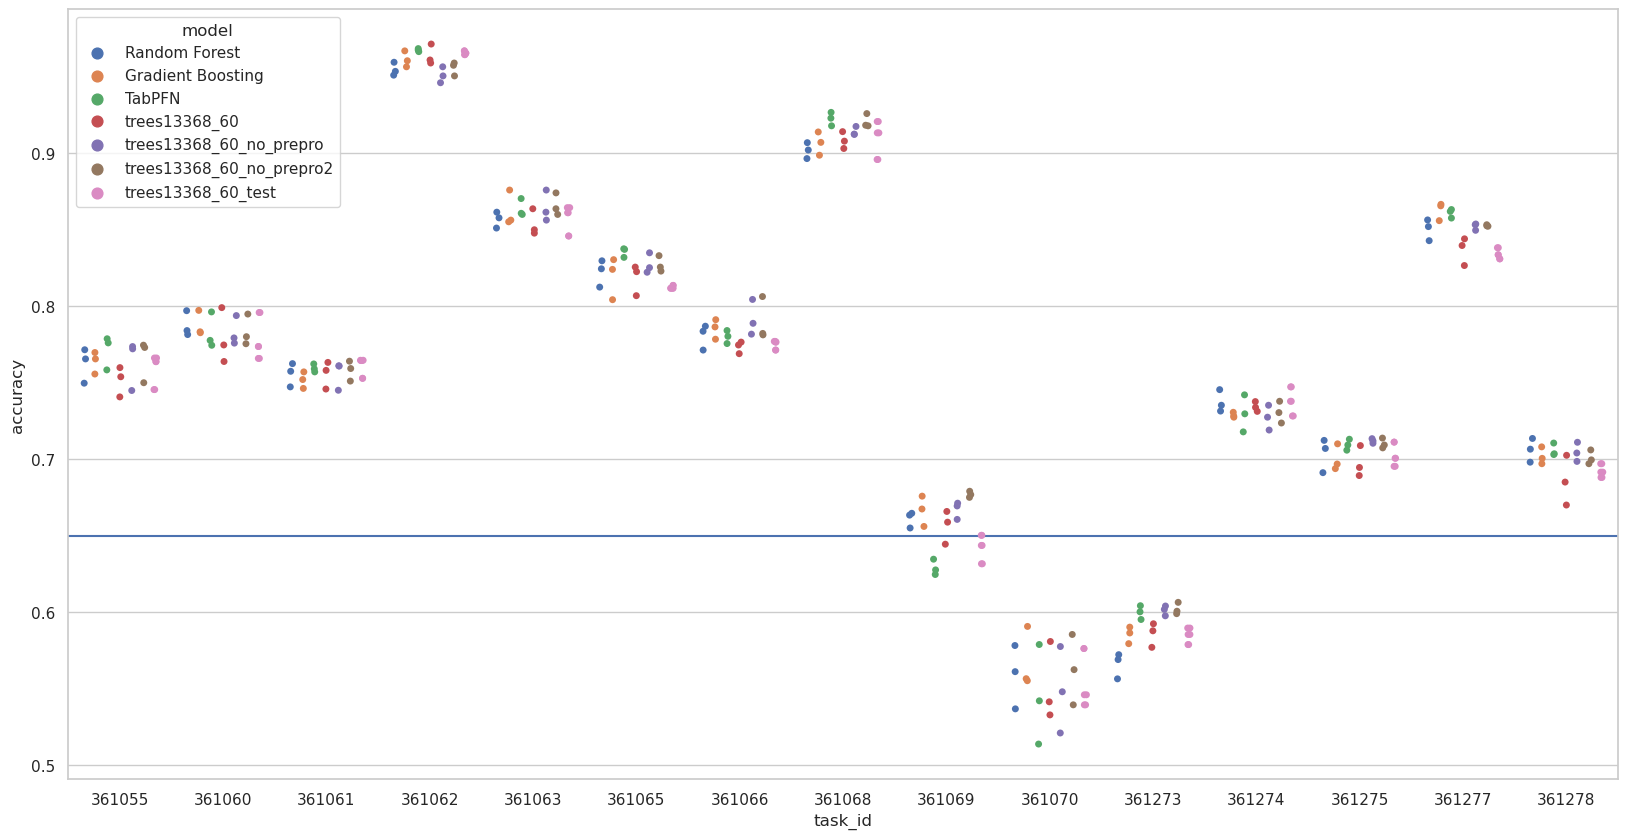

In [26]:
# Plot the results
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="whitegrid")
fig = plt.figure(figsize=(20, 10))
# Convert tasks to string
#results = pd.read_csv("results.csv")
results["task_id"] = results["task_id"].astype(str)
# Remove models which contains "default" or "mlp"
#results = results[~results["model"].str.contains("default")]
results = results[~results["model"].str.contains("mlp")]
results = results[~results["model"].str.contains("TabPFNne")]
results = results[~results["model"].str.contains("Logistic")]
results = results[~results["model"].str.contains("trees66554_75")]
results = results[~results["model"].str.contains("TabPFNno_prepro")]
results = results[np.isin(results["model"], ["Gradient Boosting", "Random Forest", "TabPFN", "trees13368_60", "trees13368_60_test", "trees13368_60_no_prepro", "trees13368_60_no_prepro2"])]
#results = results[~results["model"].str.contains("trees")]
# create a variable to distinguish between no_prepro and no_prepro2 and nothing
# model_type = []
# for model in results["model"]:
#     if "no_prepro" in model:
#         if model == "TabPFNno_prepro":
#             model_type.append(model)
#         elif "no_prepro2" in model:
#             model_type.append("no_prepro2")
#         else:
#             model_type.append("no_prepro")
#     else:
#         if "tree" in model:
#             model_type.append("prepro")
#         else:
#             model_type.append(model)
# results["model_type"] = model_type
# Plot
graph = sns.stripplot(x="task_id", y="accuracy", hue="model", data=results, dodge=True)
# horizontal line for 0.65
graph.axhline(y=0.65)
plt.show()


In [32]:
graph.axhline(y=0.63)
plt.show()

In [30]:
print(2)

2


In [11]:
# Compute mean rank of each model
results = pd.read_csv("results.csv")
results["task_id"] = results["task_id"].astype(str)
results = results[~results["model"].str.contains("mlp")]
results = results[~results["model"].str.contains("TabPFNne")]
results = results[~results["model"].str.contains("Logistic")]
results = results[~results["model"].str.contains("trees66554_75")]
results = results[~results["model"].str.contains("TabPFNno_prepro")]

# group by model and task_id, and compute the mean accuracy
mean_acc = results.groupby(['model', 'task_id']).mean()


# sort the resulting dataframe by model and accuracy
sorted_acc = mean_acc.sort_values(['model', 'accuracy'], ascending=[True, False])

# assign ranks to each model based on sorted order of accuracy
sorted_acc['rank'] = sorted_acc.groupby('task_id')['accuracy'].rank(method='dense', ascending=False)


# compute the mean rank for each model
mean_rank = sorted_acc.groupby('model')['rank'].mean()

mean_rank

model
Gradient Boosting               5.866667
Random Forest                   5.866667
TabPFN                          4.133333
default35702_250                8.466667
default35702_250_no_prepro2     7.800000
default35970_260               10.533333
trees13368_60                   8.666667
trees13368_60_no_prepro         4.666667
trees13368_60_no_prepro2        3.066667
trees456_390                    8.866667
trees456_390_no_prepro          4.666667
trees456_390_no_prepro2         3.400000
trees79428_250                  8.333333
trees79428_250_no_prepro2       8.266667
Name: rank, dtype: float64

In [59]:
import pandas as pd

# compute the maximum and minimum accuracy for each task
task_acc_range = results.groupby('task_id')['accuracy'].agg(['max', 'min'])

# merge the maximum and minimum accuracy with the original dataframe
merged_df = pd.merge(results, task_acc_range, on='task_id')

# compute the range of accuracy for each task
merged_df['range'] = merged_df['max'] - merged_df['min']

# compute the normalized accuracy for each task
merged_df['normalized_accuracy'] = (merged_df['accuracy'] - merged_df['min']) / merged_df['range']

# compute the mean normalized accuracy for each model
mean_normalized_acc = merged_df.groupby('model')['normalized_accuracy'].mean()

print(mean_normalized_acc)


model
Gradient Boosting              0.640269
Random Forest                  0.578087
TabPFN                         0.717888
default35702_250               0.522051
default35702_250_no_prepro2    0.539844
default35970_260               0.303022
trees13368_60                  0.506090
trees13368_60_no_prepro        0.668238
trees13368_60_no_prepro2       0.719841
trees456_390                   0.519045
trees456_390_no_prepro         0.668238
trees456_390_no_prepro2        0.714873
trees79428_250                 0.518346
trees79428_250_no_prepro2      0.528950
Name: normalized_accuracy, dtype: float64


In [ ]:
plt.show()

In [ ]:
# Use plotnine to plot the results
import plotnine


# Convert tasks to string
results["task_id"] = results["task_id"].astype(str)
# Make the figure bigger in plotnine
plotnine.options.figure_size = (20, 10)
# Plot
# Dodge
# special shape for checkpoints
(plotnine.ggplot(results, plotnine.aes(x="task_id", y="accuracy", color="model", shape=~results["model"].isin(["Random Forest", "Gradient Boosting", "TabPFN", "TabPFNne", "Logistic Regression"]))) +
    plotnine.geom_jitter(position=plotnine.position_dodge(width=0.9)))

# Same for categorical data

In [7]:
# Do the same thing for all tasks in openml suite 2
# and put everything in a pd dataframe
import pandas as pd
suite = openml.study.get_suite(334) # categorical classification
tasks = suite.tasks

n_repeat = 3

results = pd.DataFrame(columns=["task_id", "accuracy", "model"])
for task_id in tasks:
    print("Task id: {}".format(task_id))
    X, y, _ = import_open_ml_data(task_id=task_id, remove_nans=True, impute_nans=False, categorical=True, regression=False, balance=True, rng=None)
    if X.shape[1] > 100:
        print("skipping task {} because it has too many features".format(task_id))
        continue
    if X is None:
        print("skipping task {} because it has no features".format(task_id))
        continue

    # Evaluate the models n_repeat times

    for i in range(n_repeat):
        # Split the data into a training set and a test set
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=i)

        # Restrict to 1000 samples for faster training
        X_train, y_train = X_train[:1000], y_train[:1000]
        X_test, y_test = X_test[:5000], y_test[:5000]

        # Train a classifier
        clf = RandomForestClassifier()
        clf.fit(X_train, y_train)

        # Score the classifier
        accuracy = clf.score(X_test, y_test)
        results = results.append({"task_id": task_id, "accuracy": accuracy, "model": "Random Forest"}, ignore_index=True)

        # Train a classifier
        clf = GradientBoostingClassifier()
        clf.fit(X_train, y_train)

        # Score the classifier
        accuracy = clf.score(X_test, y_test)
        results = results.append({"task_id": task_id, "accuracy": accuracy, "model": "Gradient Boosting"}, ignore_index=True)

        # TabPFN
        model = TabPFNClassifier(N_ensemble_configurations=1)
        model.fit(X_train, y_train)

        # Score the classifier
        accuracy = model.score(X_test, y_test)
        results = results.append({"task_id": task_id, "accuracy": accuracy, "model": "TabPFNne"}, ignore_index=True)

        # TabPFN
        model = TabPFNClassifier()
        model.fit(X_train, y_train)

        # Score the classifier
        accuracy = model.score(X_test, y_test)
        results = results.append({"task_id": task_id, "accuracy": accuracy, "model": "TabPFN"}, ignore_index=True)
        # Replace model in TabPFN
        model = TabPFNClassifier(no_preprocess_mode=True)
        model_pytorch = load_model("tabpfn/model_checkpoints", "model_trees13368_60.pt", 2, model.c, 1)[0]
        model.model = model_pytorch

        # Fit
        model.fit(X_train, y_train)

        # Score the classifier
        accuracy = model.score(X_test, y_test)
        results = results.append({"task_id": task_id, "accuracy": accuracy, "model": "TabPFN trees"}, ignore_index=True)


        # Replace model in TabPFN
        model = TabPFNClassifier(no_preprocess_mode=True)
        model_pytorch = load_model("tabpfn/model_checkpoints", "model_trees456_45.pt", 2, model.c, 1)[0]
        model.model = model_pytorch

        # Fit
        model.fit(X_train, y_train)

        # Score the classifier
        accuracy = model.score(X_test, y_test)
        results = results.append({"task_id": task_id, "accuracy": accuracy, "model": "TabPFN trees 2"}, ignore_index=True)

results.to_csv("results_categorical.csv")    




Task id: 361110
1 categorical columns
8 columns
Balancing
(38474, 8)
n_samples_min_class 19237


/tmp/ipykernel_26066/406963134.py:48: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  X.iloc[:, i] = X.iloc[:, i].cat.codes
/tmp/ipykernel_26066/406963134.py:47: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  X.iloc[:, i] = X.iloc[:, i].astype('category')
/tmp/ipykernel_26066/406963134.py:48: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetit

Using style prior: True
{'recompute_attn': True}
<module 'wandb' from '/home/parietal/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/wandb/__init__.py'>
Using cpu device
Batch size: 1
Using a Transformer with 25.82 M parameters
interface
torch.Size([6000, 1, 8])
torch.Size([6000, 1])
1000


/tmp/ipykernel_26066/3582473003.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({"task_id": task_id, "accuracy": accuracy, "model": "TabPFNne"}, ignore_index=True)


Using style prior: True
{'recompute_attn': True}
<module 'wandb' from '/home/parietal/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/wandb/__init__.py'>
Using cpu device
Batch size: 1
Using a Transformer with 25.82 M parameters
interface
torch.Size([6000, 1, 8])
torch.Size([6000, 1])
1000


/tmp/ipykernel_26066/3582473003.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({"task_id": task_id, "accuracy": accuracy, "model": "TabPFN"}, ignore_index=True)


Using style prior: True
{'recompute_attn': True}
<module 'wandb' from '/home/parietal/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/wandb/__init__.py'>
Using cpu device
Batch size: 1
Using a Transformer with 25.82 M parameters
Using style prior: True
{'recompute_attn': True}
<module 'wandb' from '/home/parietal/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/wandb/__init__.py'>
Using 2 device
Batch size: 1
Using a Transformer with 25.82 M parameters
Using distributed training: False
interface
torch.Size([6000, 1, 8])
torch.Size([6000, 1])
1000


/tmp/ipykernel_26066/3582473003.py:71: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({"task_id": task_id, "accuracy": accuracy, "model": "TabPFN trees"}, ignore_index=True)


Using style prior: True
{'recompute_attn': True}
<module 'wandb' from '/home/parietal/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/wandb/__init__.py'>
Using cpu device
Batch size: 1
Using a Transformer with 25.82 M parameters
Using style prior: True
{'recompute_attn': True}
<module 'wandb' from '/home/parietal/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/wandb/__init__.py'>
Using 2 device
Batch size: 1
Using a Transformer with 25.82 M parameters
Using distributed training: False
interface
torch.Size([6000, 1, 8])
torch.Size([6000, 1])
1000


/tmp/ipykernel_26066/3582473003.py:84: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({"task_id": task_id, "accuracy": accuracy, "model": "TabPFN trees 2"}, ignore_index=True)
/tmp/ipykernel_26066/3582473003.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({"task_id": task_id, "accuracy": accuracy, "model": "Random Forest"}, ignore_index=True)
/tmp/ipykernel_26066/3582473003.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({"task_id": task_id, "accuracy": accuracy, "model": "Gradient Boosting"}, ignore_index=True)


Using style prior: True
{'recompute_attn': True}
<module 'wandb' from '/home/parietal/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/wandb/__init__.py'>
Using cpu device
Batch size: 1
Using a Transformer with 25.82 M parameters
interface
torch.Size([6000, 1, 8])
torch.Size([6000, 1])
1000


/tmp/ipykernel_26066/3582473003.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({"task_id": task_id, "accuracy": accuracy, "model": "TabPFNne"}, ignore_index=True)


Using style prior: True
{'recompute_attn': True}
<module 'wandb' from '/home/parietal/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/wandb/__init__.py'>
Using cpu device
Batch size: 1
Using a Transformer with 25.82 M parameters
interface
torch.Size([6000, 1, 8])
torch.Size([6000, 1])
1000


/tmp/ipykernel_26066/3582473003.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({"task_id": task_id, "accuracy": accuracy, "model": "TabPFN"}, ignore_index=True)


Using style prior: True
{'recompute_attn': True}
<module 'wandb' from '/home/parietal/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/wandb/__init__.py'>
Using cpu device
Batch size: 1
Using a Transformer with 25.82 M parameters
Using style prior: True
{'recompute_attn': True}
<module 'wandb' from '/home/parietal/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/wandb/__init__.py'>
Using 2 device
Batch size: 1
Using a Transformer with 25.82 M parameters
Using distributed training: False
interface
torch.Size([6000, 1, 8])
torch.Size([6000, 1])
1000


/tmp/ipykernel_26066/3582473003.py:71: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({"task_id": task_id, "accuracy": accuracy, "model": "TabPFN trees"}, ignore_index=True)


Using style prior: True
{'recompute_attn': True}
<module 'wandb' from '/home/parietal/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/wandb/__init__.py'>
Using cpu device
Batch size: 1
Using a Transformer with 25.82 M parameters
Using style prior: True
{'recompute_attn': True}
<module 'wandb' from '/home/parietal/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/wandb/__init__.py'>
Using 2 device
Batch size: 1
Using a Transformer with 25.82 M parameters
Using distributed training: False
interface
torch.Size([6000, 1, 8])
torch.Size([6000, 1])
1000


/tmp/ipykernel_26066/3582473003.py:84: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({"task_id": task_id, "accuracy": accuracy, "model": "TabPFN trees 2"}, ignore_index=True)
/tmp/ipykernel_26066/3582473003.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({"task_id": task_id, "accuracy": accuracy, "model": "Random Forest"}, ignore_index=True)
/tmp/ipykernel_26066/3582473003.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({"task_id": task_id, "accuracy": accuracy, "model": "Gradient Boosting"}, ignore_index=True)


Using style prior: True
{'recompute_attn': True}
<module 'wandb' from '/home/parietal/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/wandb/__init__.py'>
Using cpu device
Batch size: 1
Using a Transformer with 25.82 M parameters
interface
torch.Size([6000, 1, 8])
torch.Size([6000, 1])
1000


/tmp/ipykernel_26066/3582473003.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({"task_id": task_id, "accuracy": accuracy, "model": "TabPFNne"}, ignore_index=True)


Using style prior: True
{'recompute_attn': True}
<module 'wandb' from '/home/parietal/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/wandb/__init__.py'>
Using cpu device
Batch size: 1
Using a Transformer with 25.82 M parameters
interface
torch.Size([6000, 1, 8])
torch.Size([6000, 1])
1000


/tmp/ipykernel_26066/3582473003.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({"task_id": task_id, "accuracy": accuracy, "model": "TabPFN"}, ignore_index=True)


Using style prior: True
{'recompute_attn': True}
<module 'wandb' from '/home/parietal/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/wandb/__init__.py'>
Using cpu device
Batch size: 1
Using a Transformer with 25.82 M parameters
Using style prior: True
{'recompute_attn': True}
<module 'wandb' from '/home/parietal/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/wandb/__init__.py'>
Using 2 device
Batch size: 1
Using a Transformer with 25.82 M parameters
Using distributed training: False
interface
torch.Size([6000, 1, 8])
torch.Size([6000, 1])
1000


/tmp/ipykernel_26066/3582473003.py:71: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({"task_id": task_id, "accuracy": accuracy, "model": "TabPFN trees"}, ignore_index=True)


Using style prior: True
{'recompute_attn': True}
<module 'wandb' from '/home/parietal/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/wandb/__init__.py'>
Using cpu device
Batch size: 1
Using a Transformer with 25.82 M parameters
Using style prior: True
{'recompute_attn': True}
<module 'wandb' from '/home/parietal/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/wandb/__init__.py'>
Using 2 device
Batch size: 1
Using a Transformer with 25.82 M parameters
Using distributed training: False
interface
torch.Size([6000, 1, 8])
torch.Size([6000, 1])
1000


/tmp/ipykernel_26066/3582473003.py:84: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({"task_id": task_id, "accuracy": accuracy, "model": "TabPFN trees 2"}, ignore_index=True)


Task id: 361111
3 categorical columns
23 columns
Balancing
(7608, 23)
n_samples_min_class 3804


/tmp/ipykernel_26066/406963134.py:48: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  X.iloc[:, i] = X.iloc[:, i].cat.codes
/tmp/ipykernel_26066/406963134.py:48: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  X.iloc[:, i] = X.iloc[:, i].cat.codes
/tmp/ipykernel_26066/406963134.py:47: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, new

Using style prior: True
{'recompute_attn': True}
<module 'wandb' from '/home/parietal/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/wandb/__init__.py'>
Using cpu device
Batch size: 1
Using a Transformer with 25.82 M parameters
interface
torch.Size([2522, 1, 23])
torch.Size([2522, 1])
1000


/tmp/ipykernel_26066/3582473003.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({"task_id": task_id, "accuracy": accuracy, "model": "TabPFNne"}, ignore_index=True)


Using style prior: True
{'recompute_attn': True}
<module 'wandb' from '/home/parietal/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/wandb/__init__.py'>
Using cpu device
Batch size: 1
Using a Transformer with 25.82 M parameters
interface
torch.Size([2522, 1, 23])
torch.Size([2522, 1])
1000


/tmp/ipykernel_26066/3582473003.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({"task_id": task_id, "accuracy": accuracy, "model": "TabPFN"}, ignore_index=True)


Using style prior: True
{'recompute_attn': True}
<module 'wandb' from '/home/parietal/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/wandb/__init__.py'>
Using cpu device
Batch size: 1
Using a Transformer with 25.82 M parameters
Using style prior: True
{'recompute_attn': True}
<module 'wandb' from '/home/parietal/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/wandb/__init__.py'>
Using 2 device
Batch size: 1
Using a Transformer with 25.82 M parameters
Using distributed training: False
interface
torch.Size([2522, 1, 23])
torch.Size([2522, 1])
1000


/tmp/ipykernel_26066/3582473003.py:71: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({"task_id": task_id, "accuracy": accuracy, "model": "TabPFN trees"}, ignore_index=True)


Using style prior: True
{'recompute_attn': True}
<module 'wandb' from '/home/parietal/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/wandb/__init__.py'>
Using cpu device
Batch size: 1
Using a Transformer with 25.82 M parameters
Using style prior: True
{'recompute_attn': True}
<module 'wandb' from '/home/parietal/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/wandb/__init__.py'>
Using 2 device
Batch size: 1
Using a Transformer with 25.82 M parameters
Using distributed training: False
interface
torch.Size([2522, 1, 23])
torch.Size([2522, 1])
1000


/tmp/ipykernel_26066/3582473003.py:84: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({"task_id": task_id, "accuracy": accuracy, "model": "TabPFN trees 2"}, ignore_index=True)
/tmp/ipykernel_26066/3582473003.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({"task_id": task_id, "accuracy": accuracy, "model": "Random Forest"}, ignore_index=True)
/tmp/ipykernel_26066/3582473003.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({"task_id": task_id, "accuracy": accuracy, "model": "Gradient Boosting"}, ignore_index=True)


Using style prior: True
{'recompute_attn': True}
<module 'wandb' from '/home/parietal/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/wandb/__init__.py'>
Using cpu device
Batch size: 1
Using a Transformer with 25.82 M parameters
interface
torch.Size([2522, 1, 23])
torch.Size([2522, 1])
1000


/tmp/ipykernel_26066/3582473003.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({"task_id": task_id, "accuracy": accuracy, "model": "TabPFNne"}, ignore_index=True)


Using style prior: True
{'recompute_attn': True}
<module 'wandb' from '/home/parietal/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/wandb/__init__.py'>
Using cpu device
Batch size: 1
Using a Transformer with 25.82 M parameters
interface
torch.Size([2522, 1, 23])
torch.Size([2522, 1])
1000


/tmp/ipykernel_26066/3582473003.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({"task_id": task_id, "accuracy": accuracy, "model": "TabPFN"}, ignore_index=True)


Using style prior: True
{'recompute_attn': True}
<module 'wandb' from '/home/parietal/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/wandb/__init__.py'>
Using cpu device
Batch size: 1
Using a Transformer with 25.82 M parameters
Using style prior: True
{'recompute_attn': True}
<module 'wandb' from '/home/parietal/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/wandb/__init__.py'>
Using 2 device
Batch size: 1
Using a Transformer with 25.82 M parameters
Using distributed training: False
interface
torch.Size([2522, 1, 23])
torch.Size([2522, 1])
1000


/tmp/ipykernel_26066/3582473003.py:71: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({"task_id": task_id, "accuracy": accuracy, "model": "TabPFN trees"}, ignore_index=True)


Using style prior: True
{'recompute_attn': True}
<module 'wandb' from '/home/parietal/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/wandb/__init__.py'>
Using cpu device
Batch size: 1
Using a Transformer with 25.82 M parameters
Using style prior: True
{'recompute_attn': True}
<module 'wandb' from '/home/parietal/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/wandb/__init__.py'>
Using 2 device
Batch size: 1
Using a Transformer with 25.82 M parameters
Using distributed training: False
interface
torch.Size([2522, 1, 23])
torch.Size([2522, 1])
1000


/tmp/ipykernel_26066/3582473003.py:84: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({"task_id": task_id, "accuracy": accuracy, "model": "TabPFN trees 2"}, ignore_index=True)
/tmp/ipykernel_26066/3582473003.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({"task_id": task_id, "accuracy": accuracy, "model": "Random Forest"}, ignore_index=True)
/tmp/ipykernel_26066/3582473003.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({"task_id": task_id, "accuracy": accuracy, "model": "Gradient Boosting"}, ignore_index=True)


Using style prior: True
{'recompute_attn': True}
<module 'wandb' from '/home/parietal/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/wandb/__init__.py'>
Using cpu device
Batch size: 1
Using a Transformer with 25.82 M parameters
interface
torch.Size([2522, 1, 23])
torch.Size([2522, 1])
1000


/tmp/ipykernel_26066/3582473003.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({"task_id": task_id, "accuracy": accuracy, "model": "TabPFNne"}, ignore_index=True)


Using style prior: True
{'recompute_attn': True}
<module 'wandb' from '/home/parietal/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/wandb/__init__.py'>
Using cpu device
Batch size: 1
Using a Transformer with 25.82 M parameters
interface
torch.Size([2522, 1, 23])
torch.Size([2522, 1])
1000


/tmp/ipykernel_26066/3582473003.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({"task_id": task_id, "accuracy": accuracy, "model": "TabPFN"}, ignore_index=True)


Using style prior: True
{'recompute_attn': True}
<module 'wandb' from '/home/parietal/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/wandb/__init__.py'>
Using cpu device
Batch size: 1
Using a Transformer with 25.82 M parameters
Using style prior: True
{'recompute_attn': True}
<module 'wandb' from '/home/parietal/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/wandb/__init__.py'>
Using 2 device
Batch size: 1
Using a Transformer with 25.82 M parameters
Using distributed training: False
interface
torch.Size([2522, 1, 23])
torch.Size([2522, 1])
1000


/tmp/ipykernel_26066/3582473003.py:71: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({"task_id": task_id, "accuracy": accuracy, "model": "TabPFN trees"}, ignore_index=True)


Using style prior: True
{'recompute_attn': True}
<module 'wandb' from '/home/parietal/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/wandb/__init__.py'>
Using cpu device
Batch size: 1
Using a Transformer with 25.82 M parameters
Using style prior: True
{'recompute_attn': True}
<module 'wandb' from '/home/parietal/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/wandb/__init__.py'>
Using 2 device
Batch size: 1
Using a Transformer with 25.82 M parameters
Using distributed training: False
interface
torch.Size([2522, 1, 23])
torch.Size([2522, 1])
1000


/tmp/ipykernel_26066/3582473003.py:84: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({"task_id": task_id, "accuracy": accuracy, "model": "TabPFN trees 2"}, ignore_index=True)


Task id: 361113
44 categorical columns
54 columns


/tmp/ipykernel_26066/406963134.py:48: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  X.iloc[:, i] = X.iloc[:, i].cat.codes
/tmp/ipykernel_26066/406963134.py:48: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  X.iloc[:, i] = X.iloc[:, i].cat.codes
/tmp/ipykernel_26066/406963134.py:48: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, new

Balancing
(423680, 54)
n_samples_min_class 211840


/tmp/ipykernel_26066/3582473003.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({"task_id": task_id, "accuracy": accuracy, "model": "Random Forest"}, ignore_index=True)
/tmp/ipykernel_26066/3582473003.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({"task_id": task_id, "accuracy": accuracy, "model": "Gradient Boosting"}, ignore_index=True)


Using style prior: True
{'recompute_attn': True}
<module 'wandb' from '/home/parietal/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/wandb/__init__.py'>
Using cpu device
Batch size: 1
Using a Transformer with 25.82 M parameters
interface
torch.Size([6000, 1, 54])
torch.Size([6000, 1])
1000


/tmp/ipykernel_26066/3582473003.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({"task_id": task_id, "accuracy": accuracy, "model": "TabPFNne"}, ignore_index=True)


Using style prior: True
{'recompute_attn': True}
<module 'wandb' from '/home/parietal/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/wandb/__init__.py'>
Using cpu device
Batch size: 1
Using a Transformer with 25.82 M parameters
interface
torch.Size([6000, 1, 54])
torch.Size([6000, 1])
1000


/tmp/ipykernel_26066/3582473003.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({"task_id": task_id, "accuracy": accuracy, "model": "TabPFN"}, ignore_index=True)


Using style prior: True
{'recompute_attn': True}
<module 'wandb' from '/home/parietal/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/wandb/__init__.py'>
Using cpu device
Batch size: 1
Using a Transformer with 25.82 M parameters
Using style prior: True
{'recompute_attn': True}
<module 'wandb' from '/home/parietal/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/wandb/__init__.py'>
Using 2 device
Batch size: 1
Using a Transformer with 25.82 M parameters
Using distributed training: False
interface
torch.Size([6000, 1, 54])
torch.Size([6000, 1])
1000


/tmp/ipykernel_26066/3582473003.py:71: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({"task_id": task_id, "accuracy": accuracy, "model": "TabPFN trees"}, ignore_index=True)


Using style prior: True
{'recompute_attn': True}
<module 'wandb' from '/home/parietal/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/wandb/__init__.py'>
Using cpu device
Batch size: 1
Using a Transformer with 25.82 M parameters
Using style prior: True
{'recompute_attn': True}
<module 'wandb' from '/home/parietal/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/wandb/__init__.py'>
Using 2 device
Batch size: 1
Using a Transformer with 25.82 M parameters
Using distributed training: False
interface
torch.Size([6000, 1, 54])
torch.Size([6000, 1])
1000


/tmp/ipykernel_26066/3582473003.py:84: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({"task_id": task_id, "accuracy": accuracy, "model": "TabPFN trees 2"}, ignore_index=True)
/tmp/ipykernel_26066/3582473003.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({"task_id": task_id, "accuracy": accuracy, "model": "Random Forest"}, ignore_index=True)
/tmp/ipykernel_26066/3582473003.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({"task_id": task_id, "accuracy": accuracy, "model": "Gradient Boosting"}, ignore_index=True)


Using style prior: True
{'recompute_attn': True}
<module 'wandb' from '/home/parietal/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/wandb/__init__.py'>
Using cpu device
Batch size: 1
Using a Transformer with 25.82 M parameters
interface
torch.Size([6000, 1, 54])
torch.Size([6000, 1])
1000


/tmp/ipykernel_26066/3582473003.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({"task_id": task_id, "accuracy": accuracy, "model": "TabPFNne"}, ignore_index=True)


Using style prior: True
{'recompute_attn': True}
<module 'wandb' from '/home/parietal/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/wandb/__init__.py'>
Using cpu device
Batch size: 1
Using a Transformer with 25.82 M parameters
interface
torch.Size([6000, 1, 54])
torch.Size([6000, 1])
1000


/tmp/ipykernel_26066/3582473003.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({"task_id": task_id, "accuracy": accuracy, "model": "TabPFN"}, ignore_index=True)


Using style prior: True
{'recompute_attn': True}
<module 'wandb' from '/home/parietal/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/wandb/__init__.py'>
Using cpu device
Batch size: 1
Using a Transformer with 25.82 M parameters
Using style prior: True
{'recompute_attn': True}
<module 'wandb' from '/home/parietal/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/wandb/__init__.py'>
Using 2 device
Batch size: 1
Using a Transformer with 25.82 M parameters
Using distributed training: False
interface
torch.Size([6000, 1, 54])
torch.Size([6000, 1])
1000


/tmp/ipykernel_26066/3582473003.py:71: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({"task_id": task_id, "accuracy": accuracy, "model": "TabPFN trees"}, ignore_index=True)


Using style prior: True
{'recompute_attn': True}
<module 'wandb' from '/home/parietal/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/wandb/__init__.py'>
Using cpu device
Batch size: 1
Using a Transformer with 25.82 M parameters
Using style prior: True
{'recompute_attn': True}
<module 'wandb' from '/home/parietal/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/wandb/__init__.py'>
Using 2 device
Batch size: 1
Using a Transformer with 25.82 M parameters
Using distributed training: False
interface
torch.Size([6000, 1, 54])
torch.Size([6000, 1])
1000


/tmp/ipykernel_26066/3582473003.py:84: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({"task_id": task_id, "accuracy": accuracy, "model": "TabPFN trees 2"}, ignore_index=True)
/tmp/ipykernel_26066/3582473003.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({"task_id": task_id, "accuracy": accuracy, "model": "Random Forest"}, ignore_index=True)
/tmp/ipykernel_26066/3582473003.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({"task_id": task_id, "accuracy": accuracy, "model": "Gradient Boosting"}, ignore_index=True)


Using style prior: True
{'recompute_attn': True}
<module 'wandb' from '/home/parietal/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/wandb/__init__.py'>
Using cpu device
Batch size: 1
Using a Transformer with 25.82 M parameters
interface
torch.Size([6000, 1, 54])
torch.Size([6000, 1])
1000


/tmp/ipykernel_26066/3582473003.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({"task_id": task_id, "accuracy": accuracy, "model": "TabPFNne"}, ignore_index=True)


Using style prior: True
{'recompute_attn': True}
<module 'wandb' from '/home/parietal/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/wandb/__init__.py'>
Using cpu device
Batch size: 1
Using a Transformer with 25.82 M parameters
interface
torch.Size([6000, 1, 54])
torch.Size([6000, 1])
1000


/tmp/ipykernel_26066/3582473003.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({"task_id": task_id, "accuracy": accuracy, "model": "TabPFN"}, ignore_index=True)


Using style prior: True
{'recompute_attn': True}
<module 'wandb' from '/home/parietal/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/wandb/__init__.py'>
Using cpu device
Batch size: 1
Using a Transformer with 25.82 M parameters
Using style prior: True
{'recompute_attn': True}
<module 'wandb' from '/home/parietal/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/wandb/__init__.py'>
Using 2 device
Batch size: 1
Using a Transformer with 25.82 M parameters
Using distributed training: False
interface
torch.Size([6000, 1, 54])
torch.Size([6000, 1])
1000


/tmp/ipykernel_26066/3582473003.py:71: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({"task_id": task_id, "accuracy": accuracy, "model": "TabPFN trees"}, ignore_index=True)


Using style prior: True
{'recompute_attn': True}
<module 'wandb' from '/home/parietal/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/wandb/__init__.py'>
Using cpu device
Batch size: 1
Using a Transformer with 25.82 M parameters
Using style prior: True
{'recompute_attn': True}
<module 'wandb' from '/home/parietal/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/wandb/__init__.py'>
Using 2 device
Batch size: 1
Using a Transformer with 25.82 M parameters
Using distributed training: False
interface
torch.Size([6000, 1, 54])
torch.Size([6000, 1])
1000


/tmp/ipykernel_26066/3582473003.py:84: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({"task_id": task_id, "accuracy": accuracy, "model": "TabPFN trees 2"}, ignore_index=True)


Task id: 361282
10 categorical columns
31 columns
Balancing
(58252, 31)
n_samples_min_class 29126


/tmp/ipykernel_26066/406963134.py:48: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  X.iloc[:, i] = X.iloc[:, i].cat.codes
/tmp/ipykernel_26066/406963134.py:48: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  X.iloc[:, i] = X.iloc[:, i].cat.codes
/tmp/ipykernel_26066/406963134.py:48: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, new

Using style prior: True
{'recompute_attn': True}
<module 'wandb' from '/home/parietal/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/wandb/__init__.py'>
Using cpu device
Batch size: 1
Using a Transformer with 25.82 M parameters
interface
torch.Size([6000, 1, 31])
torch.Size([6000, 1])
1000


/tmp/ipykernel_26066/3582473003.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({"task_id": task_id, "accuracy": accuracy, "model": "TabPFNne"}, ignore_index=True)


Using style prior: True
{'recompute_attn': True}
<module 'wandb' from '/home/parietal/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/wandb/__init__.py'>
Using cpu device
Batch size: 1
Using a Transformer with 25.82 M parameters
interface
torch.Size([6000, 1, 31])
torch.Size([6000, 1])
1000


/tmp/ipykernel_26066/3582473003.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({"task_id": task_id, "accuracy": accuracy, "model": "TabPFN"}, ignore_index=True)


Using style prior: True
{'recompute_attn': True}
<module 'wandb' from '/home/parietal/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/wandb/__init__.py'>
Using cpu device
Batch size: 1
Using a Transformer with 25.82 M parameters
Using style prior: True
{'recompute_attn': True}
<module 'wandb' from '/home/parietal/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/wandb/__init__.py'>
Using 2 device
Batch size: 1
Using a Transformer with 25.82 M parameters
Using distributed training: False
interface
torch.Size([6000, 1, 31])
torch.Size([6000, 1])
1000


/tmp/ipykernel_26066/3582473003.py:71: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({"task_id": task_id, "accuracy": accuracy, "model": "TabPFN trees"}, ignore_index=True)


Using style prior: True
{'recompute_attn': True}
<module 'wandb' from '/home/parietal/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/wandb/__init__.py'>
Using cpu device
Batch size: 1
Using a Transformer with 25.82 M parameters
Using style prior: True
{'recompute_attn': True}
<module 'wandb' from '/home/parietal/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/wandb/__init__.py'>
Using 2 device
Batch size: 1
Using a Transformer with 25.82 M parameters
Using distributed training: False
interface
torch.Size([6000, 1, 31])
torch.Size([6000, 1])
1000


/tmp/ipykernel_26066/3582473003.py:84: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({"task_id": task_id, "accuracy": accuracy, "model": "TabPFN trees 2"}, ignore_index=True)
/tmp/ipykernel_26066/3582473003.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({"task_id": task_id, "accuracy": accuracy, "model": "Random Forest"}, ignore_index=True)
/tmp/ipykernel_26066/3582473003.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({"task_id": task_id, "accuracy": accuracy, "model": "Gradient Boosting"}, ignore_index=True)


Using style prior: True
{'recompute_attn': True}
<module 'wandb' from '/home/parietal/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/wandb/__init__.py'>
Using cpu device
Batch size: 1
Using a Transformer with 25.82 M parameters
interface
torch.Size([6000, 1, 31])
torch.Size([6000, 1])
1000


/tmp/ipykernel_26066/3582473003.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({"task_id": task_id, "accuracy": accuracy, "model": "TabPFNne"}, ignore_index=True)


Using style prior: True
{'recompute_attn': True}
<module 'wandb' from '/home/parietal/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/wandb/__init__.py'>
Using cpu device
Batch size: 1
Using a Transformer with 25.82 M parameters
interface
torch.Size([6000, 1, 31])
torch.Size([6000, 1])
1000


/tmp/ipykernel_26066/3582473003.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({"task_id": task_id, "accuracy": accuracy, "model": "TabPFN"}, ignore_index=True)


Using style prior: True
{'recompute_attn': True}
<module 'wandb' from '/home/parietal/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/wandb/__init__.py'>
Using cpu device
Batch size: 1
Using a Transformer with 25.82 M parameters
Using style prior: True
{'recompute_attn': True}
<module 'wandb' from '/home/parietal/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/wandb/__init__.py'>
Using 2 device
Batch size: 1
Using a Transformer with 25.82 M parameters
Using distributed training: False
interface
torch.Size([6000, 1, 31])
torch.Size([6000, 1])
1000


/tmp/ipykernel_26066/3582473003.py:71: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({"task_id": task_id, "accuracy": accuracy, "model": "TabPFN trees"}, ignore_index=True)


Using style prior: True
{'recompute_attn': True}
<module 'wandb' from '/home/parietal/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/wandb/__init__.py'>
Using cpu device
Batch size: 1
Using a Transformer with 25.82 M parameters
Using style prior: True
{'recompute_attn': True}
<module 'wandb' from '/home/parietal/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/wandb/__init__.py'>
Using 2 device
Batch size: 1
Using a Transformer with 25.82 M parameters
Using distributed training: False
interface
torch.Size([6000, 1, 31])
torch.Size([6000, 1])
1000


/tmp/ipykernel_26066/3582473003.py:84: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({"task_id": task_id, "accuracy": accuracy, "model": "TabPFN trees 2"}, ignore_index=True)
/tmp/ipykernel_26066/3582473003.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({"task_id": task_id, "accuracy": accuracy, "model": "Random Forest"}, ignore_index=True)
/tmp/ipykernel_26066/3582473003.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({"task_id": task_id, "accuracy": accuracy, "model": "Gradient Boosting"}, ignore_index=True)


Using style prior: True
{'recompute_attn': True}
<module 'wandb' from '/home/parietal/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/wandb/__init__.py'>
Using cpu device
Batch size: 1
Using a Transformer with 25.82 M parameters
interface
torch.Size([6000, 1, 31])
torch.Size([6000, 1])
1000


/tmp/ipykernel_26066/3582473003.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({"task_id": task_id, "accuracy": accuracy, "model": "TabPFNne"}, ignore_index=True)


Using style prior: True
{'recompute_attn': True}
<module 'wandb' from '/home/parietal/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/wandb/__init__.py'>
Using cpu device
Batch size: 1
Using a Transformer with 25.82 M parameters
interface
torch.Size([6000, 1, 31])
torch.Size([6000, 1])
1000


/tmp/ipykernel_26066/3582473003.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({"task_id": task_id, "accuracy": accuracy, "model": "TabPFN"}, ignore_index=True)


Using style prior: True
{'recompute_attn': True}
<module 'wandb' from '/home/parietal/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/wandb/__init__.py'>
Using cpu device
Batch size: 1
Using a Transformer with 25.82 M parameters
Using style prior: True
{'recompute_attn': True}
<module 'wandb' from '/home/parietal/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/wandb/__init__.py'>
Using 2 device
Batch size: 1
Using a Transformer with 25.82 M parameters
Using distributed training: False
interface
torch.Size([6000, 1, 31])
torch.Size([6000, 1])
1000


/tmp/ipykernel_26066/3582473003.py:71: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({"task_id": task_id, "accuracy": accuracy, "model": "TabPFN trees"}, ignore_index=True)


Using style prior: True
{'recompute_attn': True}
<module 'wandb' from '/home/parietal/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/wandb/__init__.py'>
Using cpu device
Batch size: 1
Using a Transformer with 25.82 M parameters
Using style prior: True
{'recompute_attn': True}
<module 'wandb' from '/home/parietal/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/wandb/__init__.py'>
Using 2 device
Batch size: 1
Using a Transformer with 25.82 M parameters
Using distributed training: False
interface
torch.Size([6000, 1, 31])
torch.Size([6000, 1])
1000


/tmp/ipykernel_26066/3582473003.py:84: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({"task_id": task_id, "accuracy": accuracy, "model": "TabPFN trees 2"}, ignore_index=True)


Task id: 361283
1 categorical columns
21 columns


/tmp/ipykernel_26066/406963134.py:48: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  X.iloc[:, i] = X.iloc[:, i].cat.codes
/tmp/ipykernel_26066/406963134.py:47: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  X.iloc[:, i] = X.iloc[:, i].astype('category')
/tmp/ipykernel_26066/406963134.py:48: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetit

Balancing
(13272, 21)
n_samples_min_class 6636


/tmp/ipykernel_26066/3582473003.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({"task_id": task_id, "accuracy": accuracy, "model": "Random Forest"}, ignore_index=True)
/tmp/ipykernel_26066/3582473003.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({"task_id": task_id, "accuracy": accuracy, "model": "Gradient Boosting"}, ignore_index=True)


Using style prior: True
{'recompute_attn': True}
<module 'wandb' from '/home/parietal/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/wandb/__init__.py'>
Using cpu device
Batch size: 1
Using a Transformer with 25.82 M parameters
interface
torch.Size([3655, 1, 21])
torch.Size([3655, 1])
1000


/tmp/ipykernel_26066/3582473003.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({"task_id": task_id, "accuracy": accuracy, "model": "TabPFNne"}, ignore_index=True)


Using style prior: True
{'recompute_attn': True}
<module 'wandb' from '/home/parietal/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/wandb/__init__.py'>
Using cpu device
Batch size: 1
Using a Transformer with 25.82 M parameters
interface
torch.Size([3655, 1, 21])
torch.Size([3655, 1])
1000


/tmp/ipykernel_26066/3582473003.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({"task_id": task_id, "accuracy": accuracy, "model": "TabPFN"}, ignore_index=True)


Using style prior: True
{'recompute_attn': True}
<module 'wandb' from '/home/parietal/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/wandb/__init__.py'>
Using cpu device
Batch size: 1
Using a Transformer with 25.82 M parameters
Using style prior: True
{'recompute_attn': True}
<module 'wandb' from '/home/parietal/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/wandb/__init__.py'>
Using 2 device
Batch size: 1
Using a Transformer with 25.82 M parameters
Using distributed training: False
interface
torch.Size([3655, 1, 21])
torch.Size([3655, 1])
1000


/tmp/ipykernel_26066/3582473003.py:71: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({"task_id": task_id, "accuracy": accuracy, "model": "TabPFN trees"}, ignore_index=True)


Using style prior: True
{'recompute_attn': True}
<module 'wandb' from '/home/parietal/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/wandb/__init__.py'>
Using cpu device
Batch size: 1
Using a Transformer with 25.82 M parameters
Using style prior: True
{'recompute_attn': True}
<module 'wandb' from '/home/parietal/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/wandb/__init__.py'>
Using 2 device
Batch size: 1
Using a Transformer with 25.82 M parameters
Using distributed training: False
interface
torch.Size([3655, 1, 21])
torch.Size([3655, 1])
1000


/tmp/ipykernel_26066/3582473003.py:84: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({"task_id": task_id, "accuracy": accuracy, "model": "TabPFN trees 2"}, ignore_index=True)
/tmp/ipykernel_26066/3582473003.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({"task_id": task_id, "accuracy": accuracy, "model": "Random Forest"}, ignore_index=True)
/tmp/ipykernel_26066/3582473003.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({"task_id": task_id, "accuracy": accuracy, "model": "Gradient Boosting"}, ignore_index=True)


Using style prior: True
{'recompute_attn': True}
<module 'wandb' from '/home/parietal/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/wandb/__init__.py'>
Using cpu device
Batch size: 1
Using a Transformer with 25.82 M parameters
interface
torch.Size([3655, 1, 21])
torch.Size([3655, 1])
1000


/tmp/ipykernel_26066/3582473003.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({"task_id": task_id, "accuracy": accuracy, "model": "TabPFNne"}, ignore_index=True)


Using style prior: True
{'recompute_attn': True}
<module 'wandb' from '/home/parietal/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/wandb/__init__.py'>
Using cpu device
Batch size: 1
Using a Transformer with 25.82 M parameters
interface
torch.Size([3655, 1, 21])
torch.Size([3655, 1])
1000


/tmp/ipykernel_26066/3582473003.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({"task_id": task_id, "accuracy": accuracy, "model": "TabPFN"}, ignore_index=True)


Using style prior: True
{'recompute_attn': True}
<module 'wandb' from '/home/parietal/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/wandb/__init__.py'>
Using cpu device
Batch size: 1
Using a Transformer with 25.82 M parameters
Using style prior: True
{'recompute_attn': True}
<module 'wandb' from '/home/parietal/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/wandb/__init__.py'>
Using 2 device
Batch size: 1
Using a Transformer with 25.82 M parameters
Using distributed training: False
interface
torch.Size([3655, 1, 21])
torch.Size([3655, 1])
1000


/tmp/ipykernel_26066/3582473003.py:71: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({"task_id": task_id, "accuracy": accuracy, "model": "TabPFN trees"}, ignore_index=True)


Using style prior: True
{'recompute_attn': True}
<module 'wandb' from '/home/parietal/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/wandb/__init__.py'>
Using cpu device
Batch size: 1
Using a Transformer with 25.82 M parameters
Using style prior: True
{'recompute_attn': True}
<module 'wandb' from '/home/parietal/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/wandb/__init__.py'>
Using 2 device
Batch size: 1
Using a Transformer with 25.82 M parameters
Using distributed training: False
interface
torch.Size([3655, 1, 21])
torch.Size([3655, 1])
1000


/tmp/ipykernel_26066/3582473003.py:84: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({"task_id": task_id, "accuracy": accuracy, "model": "TabPFN trees 2"}, ignore_index=True)
/tmp/ipykernel_26066/3582473003.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({"task_id": task_id, "accuracy": accuracy, "model": "Random Forest"}, ignore_index=True)
/tmp/ipykernel_26066/3582473003.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({"task_id": task_id, "accuracy": accuracy, "model": "Gradient Boosting"}, ignore_index=True)


Using style prior: True
{'recompute_attn': True}
<module 'wandb' from '/home/parietal/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/wandb/__init__.py'>
Using cpu device
Batch size: 1
Using a Transformer with 25.82 M parameters
interface
torch.Size([3655, 1, 21])
torch.Size([3655, 1])
1000


/tmp/ipykernel_26066/3582473003.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({"task_id": task_id, "accuracy": accuracy, "model": "TabPFNne"}, ignore_index=True)


Using style prior: True
{'recompute_attn': True}
<module 'wandb' from '/home/parietal/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/wandb/__init__.py'>
Using cpu device
Batch size: 1
Using a Transformer with 25.82 M parameters
interface
torch.Size([3655, 1, 21])
torch.Size([3655, 1])
1000


/tmp/ipykernel_26066/3582473003.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({"task_id": task_id, "accuracy": accuracy, "model": "TabPFN"}, ignore_index=True)


Using style prior: True
{'recompute_attn': True}
<module 'wandb' from '/home/parietal/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/wandb/__init__.py'>
Using cpu device
Batch size: 1
Using a Transformer with 25.82 M parameters
Using style prior: True
{'recompute_attn': True}
<module 'wandb' from '/home/parietal/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/wandb/__init__.py'>
Using 2 device
Batch size: 1
Using a Transformer with 25.82 M parameters
Using distributed training: False
interface
torch.Size([3655, 1, 21])
torch.Size([3655, 1])
1000


/tmp/ipykernel_26066/3582473003.py:71: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({"task_id": task_id, "accuracy": accuracy, "model": "TabPFN trees"}, ignore_index=True)


Using style prior: True
{'recompute_attn': True}
<module 'wandb' from '/home/parietal/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/wandb/__init__.py'>
Using cpu device
Batch size: 1
Using a Transformer with 25.82 M parameters
Using style prior: True
{'recompute_attn': True}
<module 'wandb' from '/home/parietal/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/wandb/__init__.py'>
Using 2 device
Batch size: 1
Using a Transformer with 25.82 M parameters
Using distributed training: False
interface
torch.Size([3655, 1, 21])
torch.Size([3655, 1])
1000


/tmp/ipykernel_26066/3582473003.py:84: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({"task_id": task_id, "accuracy": accuracy, "model": "TabPFN trees 2"}, ignore_index=True)


Task id: 361285
3 categorical columns
32 columns


/tmp/ipykernel_26066/406963134.py:48: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  X.iloc[:, i] = X.iloc[:, i].cat.codes
/tmp/ipykernel_26066/406963134.py:48: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  X.iloc[:, i] = X.iloc[:, i].cat.codes
/tmp/ipykernel_26066/406963134.py:48: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, new

Balancing
(111762, 32)
n_samples_min_class 55881


/tmp/ipykernel_26066/3582473003.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({"task_id": task_id, "accuracy": accuracy, "model": "Random Forest"}, ignore_index=True)
/tmp/ipykernel_26066/3582473003.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({"task_id": task_id, "accuracy": accuracy, "model": "Gradient Boosting"}, ignore_index=True)


Using style prior: True
{'recompute_attn': True}
<module 'wandb' from '/home/parietal/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/wandb/__init__.py'>
Using cpu device
Batch size: 1
Using a Transformer with 25.82 M parameters
interface
torch.Size([6000, 1, 32])
torch.Size([6000, 1])
1000


/tmp/ipykernel_26066/3582473003.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({"task_id": task_id, "accuracy": accuracy, "model": "TabPFNne"}, ignore_index=True)


Using style prior: True
{'recompute_attn': True}
<module 'wandb' from '/home/parietal/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/wandb/__init__.py'>
Using cpu device
Batch size: 1
Using a Transformer with 25.82 M parameters
interface
torch.Size([6000, 1, 32])
torch.Size([6000, 1])
1000


/tmp/ipykernel_26066/3582473003.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({"task_id": task_id, "accuracy": accuracy, "model": "TabPFN"}, ignore_index=True)


Using style prior: True
{'recompute_attn': True}
<module 'wandb' from '/home/parietal/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/wandb/__init__.py'>
Using cpu device
Batch size: 1
Using a Transformer with 25.82 M parameters
Using style prior: True
{'recompute_attn': True}
<module 'wandb' from '/home/parietal/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/wandb/__init__.py'>
Using 2 device
Batch size: 1
Using a Transformer with 25.82 M parameters
Using distributed training: False
interface
torch.Size([6000, 1, 32])
torch.Size([6000, 1])
1000


/tmp/ipykernel_26066/3582473003.py:71: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({"task_id": task_id, "accuracy": accuracy, "model": "TabPFN trees"}, ignore_index=True)


Using style prior: True
{'recompute_attn': True}
<module 'wandb' from '/home/parietal/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/wandb/__init__.py'>
Using cpu device
Batch size: 1
Using a Transformer with 25.82 M parameters
Using style prior: True
{'recompute_attn': True}
<module 'wandb' from '/home/parietal/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/wandb/__init__.py'>
Using 2 device
Batch size: 1
Using a Transformer with 25.82 M parameters
Using distributed training: False
interface
torch.Size([6000, 1, 32])
torch.Size([6000, 1])
1000


/tmp/ipykernel_26066/3582473003.py:84: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({"task_id": task_id, "accuracy": accuracy, "model": "TabPFN trees 2"}, ignore_index=True)
/tmp/ipykernel_26066/3582473003.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({"task_id": task_id, "accuracy": accuracy, "model": "Random Forest"}, ignore_index=True)
/tmp/ipykernel_26066/3582473003.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({"task_id": task_id, "accuracy": accuracy, "model": "Gradient Boosting"}, ignore_index=True)


Using style prior: True
{'recompute_attn': True}
<module 'wandb' from '/home/parietal/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/wandb/__init__.py'>
Using cpu device
Batch size: 1
Using a Transformer with 25.82 M parameters
interface
torch.Size([6000, 1, 32])
torch.Size([6000, 1])
1000


/tmp/ipykernel_26066/3582473003.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({"task_id": task_id, "accuracy": accuracy, "model": "TabPFNne"}, ignore_index=True)


Using style prior: True
{'recompute_attn': True}
<module 'wandb' from '/home/parietal/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/wandb/__init__.py'>
Using cpu device
Batch size: 1
Using a Transformer with 25.82 M parameters
interface
torch.Size([6000, 1, 32])
torch.Size([6000, 1])
1000


/tmp/ipykernel_26066/3582473003.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({"task_id": task_id, "accuracy": accuracy, "model": "TabPFN"}, ignore_index=True)


Using style prior: True
{'recompute_attn': True}
<module 'wandb' from '/home/parietal/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/wandb/__init__.py'>
Using cpu device
Batch size: 1
Using a Transformer with 25.82 M parameters
Using style prior: True
{'recompute_attn': True}
<module 'wandb' from '/home/parietal/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/wandb/__init__.py'>
Using 2 device
Batch size: 1
Using a Transformer with 25.82 M parameters
Using distributed training: False
interface
torch.Size([6000, 1, 32])
torch.Size([6000, 1])
1000


/tmp/ipykernel_26066/3582473003.py:71: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({"task_id": task_id, "accuracy": accuracy, "model": "TabPFN trees"}, ignore_index=True)


Using style prior: True
{'recompute_attn': True}
<module 'wandb' from '/home/parietal/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/wandb/__init__.py'>
Using cpu device
Batch size: 1
Using a Transformer with 25.82 M parameters
Using style prior: True
{'recompute_attn': True}
<module 'wandb' from '/home/parietal/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/wandb/__init__.py'>
Using 2 device
Batch size: 1
Using a Transformer with 25.82 M parameters
Using distributed training: False
interface
torch.Size([6000, 1, 32])
torch.Size([6000, 1])
1000


/tmp/ipykernel_26066/3582473003.py:84: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({"task_id": task_id, "accuracy": accuracy, "model": "TabPFN trees 2"}, ignore_index=True)
/tmp/ipykernel_26066/3582473003.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({"task_id": task_id, "accuracy": accuracy, "model": "Random Forest"}, ignore_index=True)
/tmp/ipykernel_26066/3582473003.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({"task_id": task_id, "accuracy": accuracy, "model": "Gradient Boosting"}, ignore_index=True)


Using style prior: True
{'recompute_attn': True}
<module 'wandb' from '/home/parietal/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/wandb/__init__.py'>
Using cpu device
Batch size: 1
Using a Transformer with 25.82 M parameters
interface
torch.Size([6000, 1, 32])
torch.Size([6000, 1])
1000


/tmp/ipykernel_26066/3582473003.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({"task_id": task_id, "accuracy": accuracy, "model": "TabPFNne"}, ignore_index=True)


Using style prior: True
{'recompute_attn': True}
<module 'wandb' from '/home/parietal/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/wandb/__init__.py'>
Using cpu device
Batch size: 1
Using a Transformer with 25.82 M parameters
interface
torch.Size([6000, 1, 32])
torch.Size([6000, 1])
1000


/tmp/ipykernel_26066/3582473003.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({"task_id": task_id, "accuracy": accuracy, "model": "TabPFN"}, ignore_index=True)


Using style prior: True
{'recompute_attn': True}
<module 'wandb' from '/home/parietal/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/wandb/__init__.py'>
Using cpu device
Batch size: 1
Using a Transformer with 25.82 M parameters
Using style prior: True
{'recompute_attn': True}
<module 'wandb' from '/home/parietal/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/wandb/__init__.py'>
Using 2 device
Batch size: 1
Using a Transformer with 25.82 M parameters
Using distributed training: False
interface
torch.Size([6000, 1, 32])
torch.Size([6000, 1])
1000


/tmp/ipykernel_26066/3582473003.py:71: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({"task_id": task_id, "accuracy": accuracy, "model": "TabPFN trees"}, ignore_index=True)


Using style prior: True
{'recompute_attn': True}
<module 'wandb' from '/home/parietal/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/wandb/__init__.py'>
Using cpu device
Batch size: 1
Using a Transformer with 25.82 M parameters
Using style prior: True
{'recompute_attn': True}
<module 'wandb' from '/home/parietal/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/wandb/__init__.py'>
Using 2 device
Batch size: 1
Using a Transformer with 25.82 M parameters
Using distributed training: False
interface
torch.Size([6000, 1, 32])
torch.Size([6000, 1])
1000


/tmp/ipykernel_26066/3582473003.py:84: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({"task_id": task_id, "accuracy": accuracy, "model": "TabPFN trees 2"}, ignore_index=True)


Task id: 361286
8 categorical columns
11 columns
Balancing
(4966, 11)
n_samples_min_class 2483


/tmp/ipykernel_26066/406963134.py:47: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  X.iloc[:, i] = X.iloc[:, i].astype('category')
/tmp/ipykernel_26066/406963134.py:48: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  X.iloc[:, i] = X.iloc[:, i].cat.codes
/tmp/ipykernel_26066/406963134.py:48: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetit

Using style prior: True
{'recompute_attn': True}
<module 'wandb' from '/home/parietal/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/wandb/__init__.py'>
Using cpu device
Batch size: 1
Using a Transformer with 25.82 M parameters
interface
torch.Size([1994, 1, 11])
torch.Size([1994, 1])
1000


/tmp/ipykernel_26066/3582473003.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({"task_id": task_id, "accuracy": accuracy, "model": "TabPFNne"}, ignore_index=True)


Using style prior: True
{'recompute_attn': True}
<module 'wandb' from '/home/parietal/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/wandb/__init__.py'>
Using cpu device
Batch size: 1
Using a Transformer with 25.82 M parameters
interface
torch.Size([1994, 1, 11])
torch.Size([1994, 1])
1000


/tmp/ipykernel_26066/3582473003.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({"task_id": task_id, "accuracy": accuracy, "model": "TabPFN"}, ignore_index=True)


Using style prior: True
{'recompute_attn': True}
<module 'wandb' from '/home/parietal/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/wandb/__init__.py'>
Using cpu device
Batch size: 1
Using a Transformer with 25.82 M parameters
Using style prior: True
{'recompute_attn': True}
<module 'wandb' from '/home/parietal/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/wandb/__init__.py'>
Using 2 device
Batch size: 1
Using a Transformer with 25.82 M parameters
Using distributed training: False
interface
torch.Size([1994, 1, 11])
torch.Size([1994, 1])
1000


/tmp/ipykernel_26066/3582473003.py:71: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({"task_id": task_id, "accuracy": accuracy, "model": "TabPFN trees"}, ignore_index=True)


Using style prior: True
{'recompute_attn': True}
<module 'wandb' from '/home/parietal/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/wandb/__init__.py'>
Using cpu device
Batch size: 1
Using a Transformer with 25.82 M parameters
Using style prior: True
{'recompute_attn': True}
<module 'wandb' from '/home/parietal/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/wandb/__init__.py'>
Using 2 device
Batch size: 1
Using a Transformer with 25.82 M parameters
Using distributed training: False
interface
torch.Size([1994, 1, 11])
torch.Size([1994, 1])
1000


/tmp/ipykernel_26066/3582473003.py:84: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({"task_id": task_id, "accuracy": accuracy, "model": "TabPFN trees 2"}, ignore_index=True)
/tmp/ipykernel_26066/3582473003.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({"task_id": task_id, "accuracy": accuracy, "model": "Random Forest"}, ignore_index=True)
/tmp/ipykernel_26066/3582473003.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({"task_id": task_id, "accuracy": accuracy, "model": "Gradient Boosting"}, ignore_index=True)


Using style prior: True
{'recompute_attn': True}
<module 'wandb' from '/home/parietal/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/wandb/__init__.py'>
Using cpu device
Batch size: 1
Using a Transformer with 25.82 M parameters
interface
torch.Size([1994, 1, 11])
torch.Size([1994, 1])
1000


/tmp/ipykernel_26066/3582473003.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({"task_id": task_id, "accuracy": accuracy, "model": "TabPFNne"}, ignore_index=True)


Using style prior: True
{'recompute_attn': True}
<module 'wandb' from '/home/parietal/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/wandb/__init__.py'>
Using cpu device
Batch size: 1
Using a Transformer with 25.82 M parameters
interface
torch.Size([1994, 1, 11])
torch.Size([1994, 1])
1000


/tmp/ipykernel_26066/3582473003.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({"task_id": task_id, "accuracy": accuracy, "model": "TabPFN"}, ignore_index=True)


Using style prior: True
{'recompute_attn': True}
<module 'wandb' from '/home/parietal/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/wandb/__init__.py'>
Using cpu device
Batch size: 1
Using a Transformer with 25.82 M parameters
Using style prior: True
{'recompute_attn': True}
<module 'wandb' from '/home/parietal/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/wandb/__init__.py'>
Using 2 device
Batch size: 1
Using a Transformer with 25.82 M parameters
Using distributed training: False
interface
torch.Size([1994, 1, 11])
torch.Size([1994, 1])
1000


/tmp/ipykernel_26066/3582473003.py:71: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({"task_id": task_id, "accuracy": accuracy, "model": "TabPFN trees"}, ignore_index=True)


Using style prior: True
{'recompute_attn': True}
<module 'wandb' from '/home/parietal/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/wandb/__init__.py'>
Using cpu device
Batch size: 1
Using a Transformer with 25.82 M parameters
Using style prior: True
{'recompute_attn': True}
<module 'wandb' from '/home/parietal/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/wandb/__init__.py'>
Using 2 device
Batch size: 1
Using a Transformer with 25.82 M parameters
Using distributed training: False
interface
torch.Size([1994, 1, 11])
torch.Size([1994, 1])
1000


/tmp/ipykernel_26066/3582473003.py:84: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({"task_id": task_id, "accuracy": accuracy, "model": "TabPFN trees 2"}, ignore_index=True)
/tmp/ipykernel_26066/3582473003.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({"task_id": task_id, "accuracy": accuracy, "model": "Random Forest"}, ignore_index=True)
/tmp/ipykernel_26066/3582473003.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({"task_id": task_id, "accuracy": accuracy, "model": "Gradient Boosting"}, ignore_index=True)


Using style prior: True
{'recompute_attn': True}
<module 'wandb' from '/home/parietal/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/wandb/__init__.py'>
Using cpu device
Batch size: 1
Using a Transformer with 25.82 M parameters
interface
torch.Size([1994, 1, 11])
torch.Size([1994, 1])
1000


/tmp/ipykernel_26066/3582473003.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({"task_id": task_id, "accuracy": accuracy, "model": "TabPFNne"}, ignore_index=True)


Using style prior: True
{'recompute_attn': True}
<module 'wandb' from '/home/parietal/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/wandb/__init__.py'>
Using cpu device
Batch size: 1
Using a Transformer with 25.82 M parameters
interface
torch.Size([1994, 1, 11])
torch.Size([1994, 1])
1000


/tmp/ipykernel_26066/3582473003.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({"task_id": task_id, "accuracy": accuracy, "model": "TabPFN"}, ignore_index=True)


Using style prior: True
{'recompute_attn': True}
<module 'wandb' from '/home/parietal/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/wandb/__init__.py'>
Using cpu device
Batch size: 1
Using a Transformer with 25.82 M parameters
Using style prior: True
{'recompute_attn': True}
<module 'wandb' from '/home/parietal/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/wandb/__init__.py'>
Using 2 device
Batch size: 1
Using a Transformer with 25.82 M parameters
Using distributed training: False
interface
torch.Size([1994, 1, 11])
torch.Size([1994, 1])
1000


/tmp/ipykernel_26066/3582473003.py:71: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({"task_id": task_id, "accuracy": accuracy, "model": "TabPFN trees"}, ignore_index=True)


Using style prior: True
{'recompute_attn': True}
<module 'wandb' from '/home/parietal/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/wandb/__init__.py'>
Using cpu device
Batch size: 1
Using a Transformer with 25.82 M parameters
Using style prior: True
{'recompute_attn': True}
<module 'wandb' from '/home/parietal/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/wandb/__init__.py'>
Using 2 device
Batch size: 1
Using a Transformer with 25.82 M parameters
Using distributed training: False
interface
torch.Size([1994, 1, 11])
torch.Size([1994, 1])
1000


/tmp/ipykernel_26066/3582473003.py:84: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({"task_id": task_id, "accuracy": accuracy, "model": "TabPFN trees 2"}, ignore_index=True)


In [2]:
import pandas as pd
results = pd.read_csv("results_categorical.csv")

In [ ]:
# Choose tasks with less than 100 features
accepted_tasks = []
for task_id in tasks:
    print("Task id: {}".format(task_id))
    X, y, _ = import_open_ml_data(task_id=task_id, remove_nans=True, impute_nans=False, categorical=True, regression=False, balance=True, rng=None)
    if X.shape[1] > 100:
        print("skipping task {} because it has too many features".format(task_id))
        continue
    if X is None:
        print("skipping task {} because it has no features".format(task_id))
        continue
    accepted_tasks.append(task_id)

results = results[results["task_id"].isin(accepted_tasks)]



In [8]:
results["task_id"] = results["task_id"].astype(str)
results = results[~results["model"].str.contains("mlp")]
results = results[~results["model"].str.contains("TabPFNne")]
results = results[~results["model"].str.contains("Logistic")]
results = results[~results["model"].str.contains("trees66554_75")]
results = results[~results["model"].str.contains("TabPFNno_prepro")]

# group by model and task_id, and compute the mean accuracy
mean_acc = results.groupby(['model', 'task_id']).mean()


# sort the resulting dataframe by model and accuracy
sorted_acc = mean_acc.sort_values(['model', 'accuracy'], ascending=[True, False])

# assign ranks to each model based on sorted order of accuracy
sorted_acc['rank'] = sorted_acc.groupby('task_id')['accuracy'].rank(method='dense', ascending=False)


# compute the mean rank for each model
mean_rank = sorted_acc.groupby('model')['rank'].mean()

mean_rank

model
Gradient Boosting    3.000000
Random Forest        2.714286
TabPFN               2.000000
TabPFN trees         3.857143
TabPFN trees 2       3.428571
Name: rank, dtype: float64

In [9]:
import pandas as pd

# compute the maximum and minimum accuracy for each task
task_acc_range = results.groupby('task_id')['accuracy'].agg(['max', 'min'])

# merge the maximum and minimum accuracy with the original dataframe
merged_df = pd.merge(results, task_acc_range, on='task_id')

# compute the range of accuracy for each task
merged_df['range'] = merged_df['max'] - merged_df['min']

# compute the normalized accuracy for each task
merged_df['normalized_accuracy'] = (merged_df['accuracy'] - merged_df['min']) / merged_df['range']

# compute the mean normalized accuracy for each model
mean_normalized_acc = merged_df.groupby('model')['normalized_accuracy'].mean()

print(mean_normalized_acc)


model
Gradient Boosting    0.525233
Random Forest        0.566216
TabPFN               0.630861
TabPFN trees         0.490196
TabPFN trees 2       0.478267
Name: normalized_accuracy, dtype: float64


/home/parietal/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/seaborn/rcmod.py:82: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
/home/parietal/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/setuptools/_distutils/version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/home/parietal/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/seaborn/cm.py:1582: MatplotlibDeprecationWarning: The register_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps.register(name)`` instead.
  mpl_cm.register_cmap(_name, _cmap)
/home/parietal/lgrinszt/.local/miniconda3/envs/tab_pfn2/lib/python3.9/site-packages/seaborn/cm.py:1583: MatplotlibDeprecationWarning: The register_cmap function was deprecated in Mat

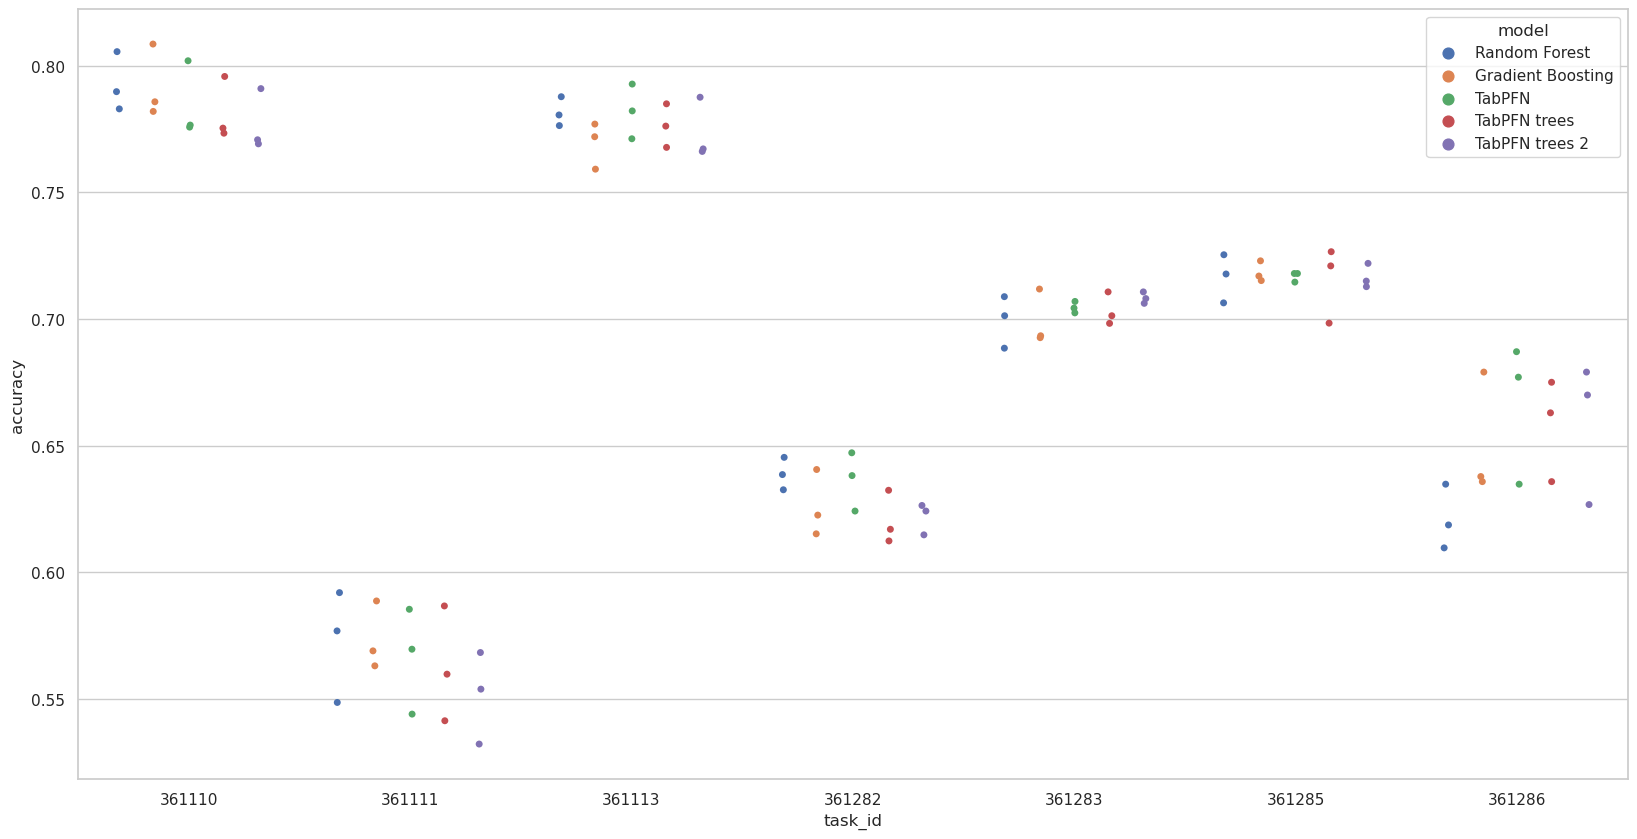

In [10]:
# Plot the results
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="whitegrid")
fig = plt.figure(figsize=(20, 10))
# Convert tasks to string
results["task_id"] = results["task_id"].astype(str)
# scatter plot with jitter
sns.stripplot(x="task_id", y="accuracy", hue="model", data=results, jitter=0.05, dodge=True)
plt.show()


In [ ]:
results